# Figures

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
from itertools import product
import tempfile

In [176]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [6]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
# GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
# PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['BCell', 'TCell']

! mkdir -p {GSE26320_PATH} /pics
! mkdir -p {IMMUNE_PATH} /pics

mkdir: cannot create directory ‘/pics’: Permission denied
mkdir: cannot create directory ‘/pics’: Permission denied


In [7]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [8]:
def load_peaks(path, suffix,
               modifications=MODIFICATIONS,
               cells=GSE26320_CELLS,
               replicates=GSE26320_REPS):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [9]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [10]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 85


,file,modification,cell,replicate,peaks,tool,dataset
83,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,HMEC,rep2,54056,MACS2,ENCODE
174,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K36me3,NHLF,rep1,44110,SICER,ENCODE
135,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,HSMM,rep2,38646,MACS2 broad,ENCODE
227,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K36me3,NHEK,rep2,46199,SICER,ENCODE
202,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K36me3,HepG2,rep1,43335,SICER,ENCODE


In [11]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, [''])
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 10


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 10


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 10


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 10


,file,modification,cell,replicate,peaks,tool,dataset
12,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K27ac,BCell,,41460,MACS2 broad,Roadmap
19,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,H3K4me1,TCell,,145437,MACS2 broad,Roadmap
18,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,H3K4me3,TCell,,28929,MACS2 broad,Roadmap
8,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K27ac,BCell,,45626,MACS2,Roadmap
5,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,H3K4me3,TCell,,31242,MACS2,Roadmap


In [12]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

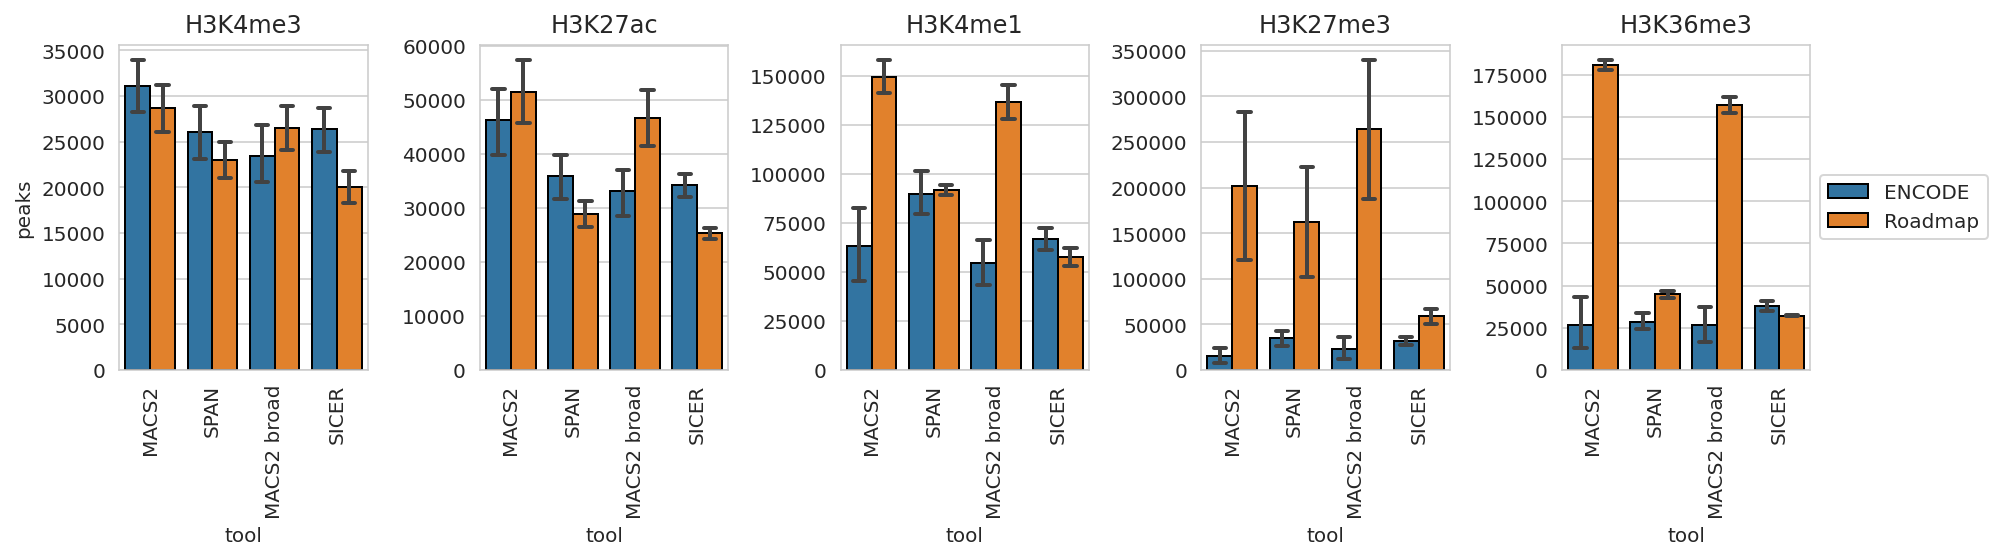

In [13]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'SPAN', 'MACS2 broad', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

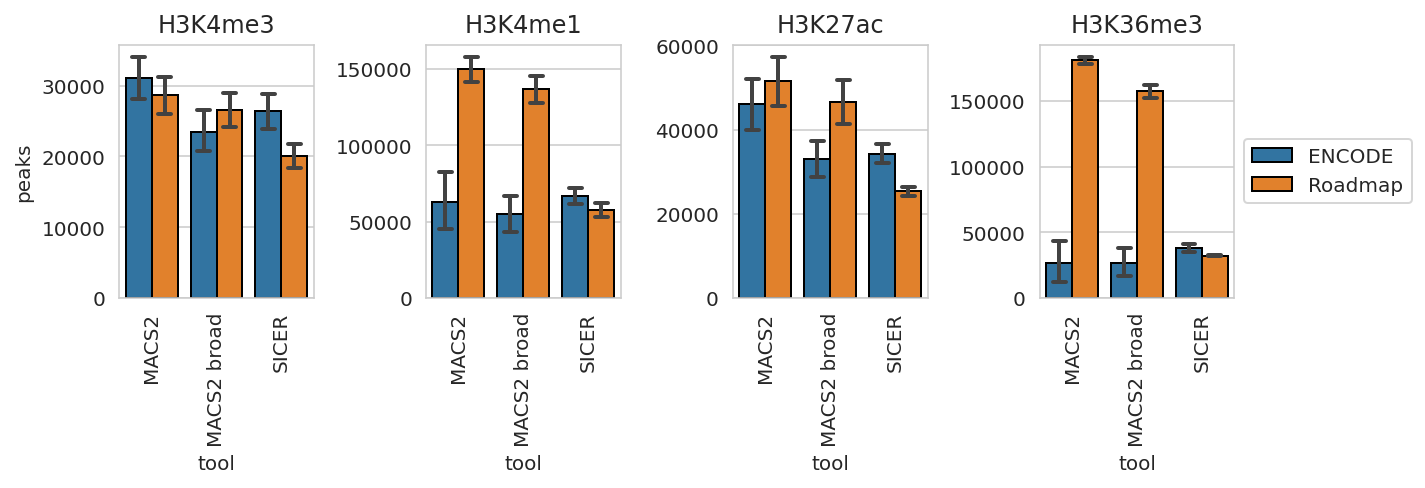

In [325]:
plt.figure(figsize=(10, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [326]:
print('Load lengths')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = dataset
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

,length,dataset,modification,cell,replicate,tool
1128879,180.0,ENCODE,H3K27me3,K562,rep2,MACS2 broad
698347,524.0,ENCODE,H3K27ac,HMEC,rep2,MACS2
187412,186.0,ENCODE,H3K4me3,HMEC,rep2,MACS2
2971984,530.0,ENCODE,H3K4me1,NHEK,rep2,SPAN
1108638,366.0,ENCODE,H3K4me1,NHLF,rep1,MACS2 broad
3543451,373.0,Roadmap,H3K4me1,BCell,,SPAN
155531,757.0,ENCODE,H3K36me3,Huvec,rep1,MACS2
83950,1006.0,ENCODE,H3K4me3,K562,rep2,MACS2
1773200,3199.0,ENCODE,H3K4me1,Huvec,rep2,SICER
2399357,5148.0,ENCODE,H3K27me3,HMEC,rep1,SPAN


H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


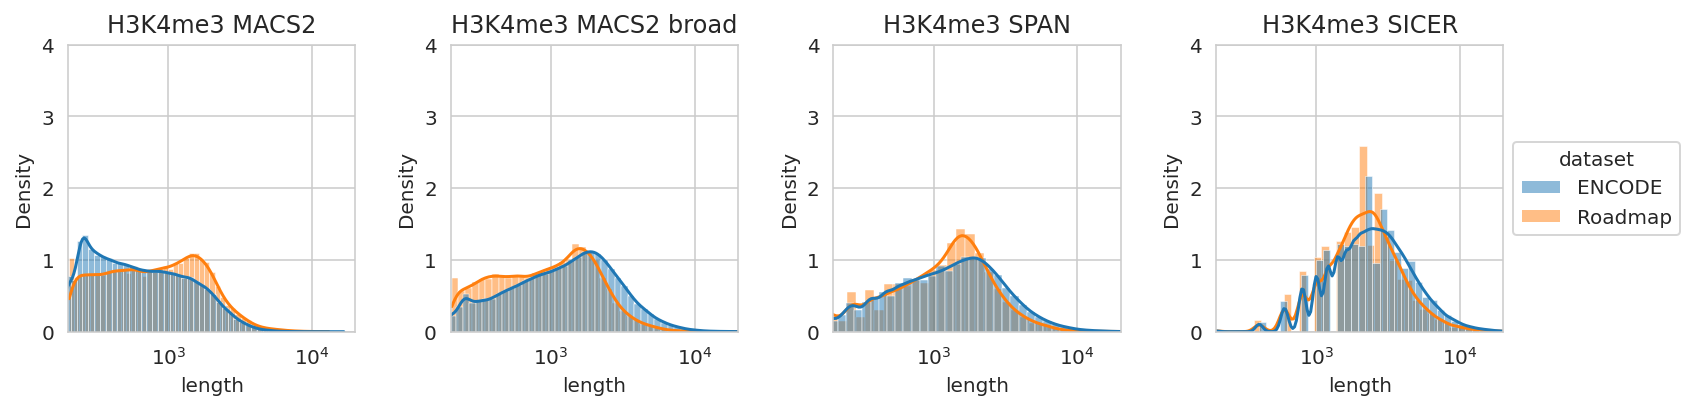

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


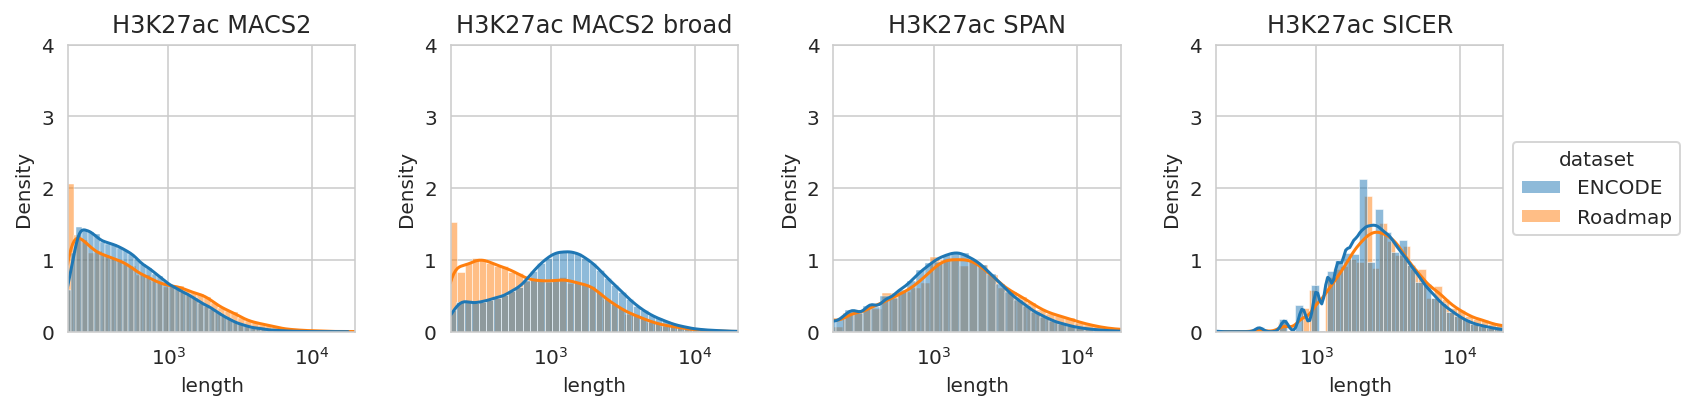

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


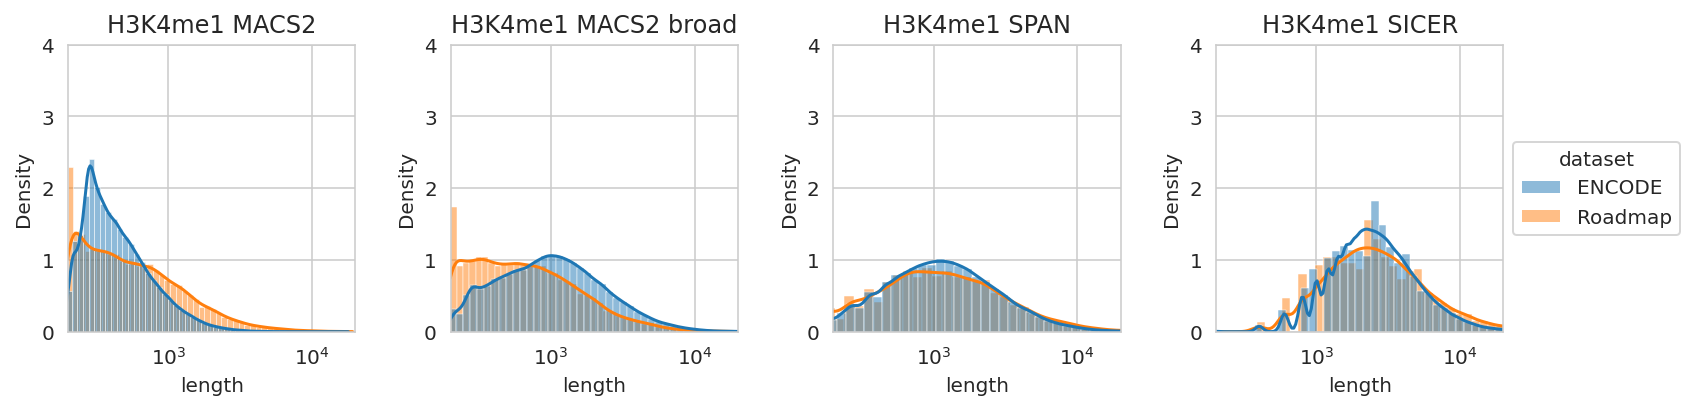

H3K27me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


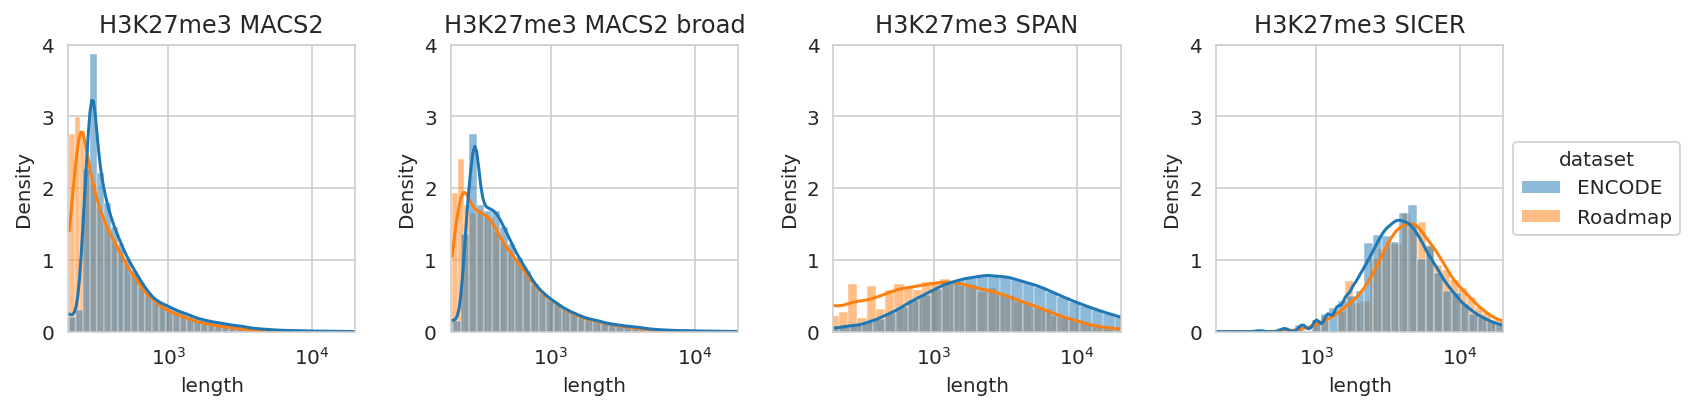

H3K36me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


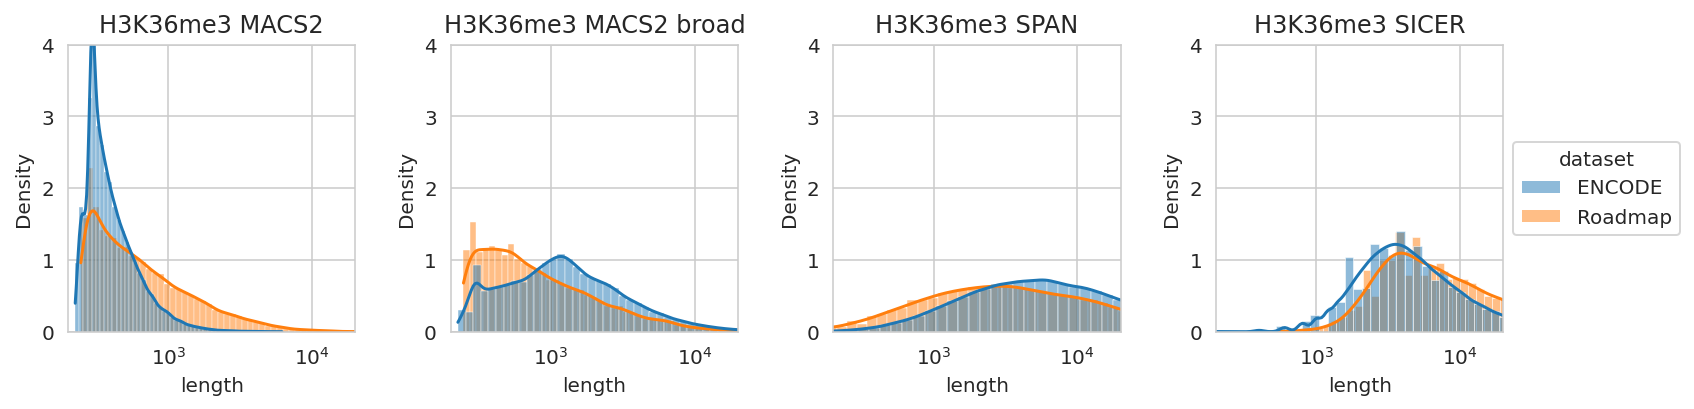

In [327]:
for m in MODIFICATIONS:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
    for i, tool in enumerate(TOOLS):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='dataset', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=50, kde=True, log_scale=True, alpha=0.5,
                                 # palette=TOOLS_PALETTE,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 4)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{m} {tool}')
        if i < 3:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))        
    plt.tight_layout()
    plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


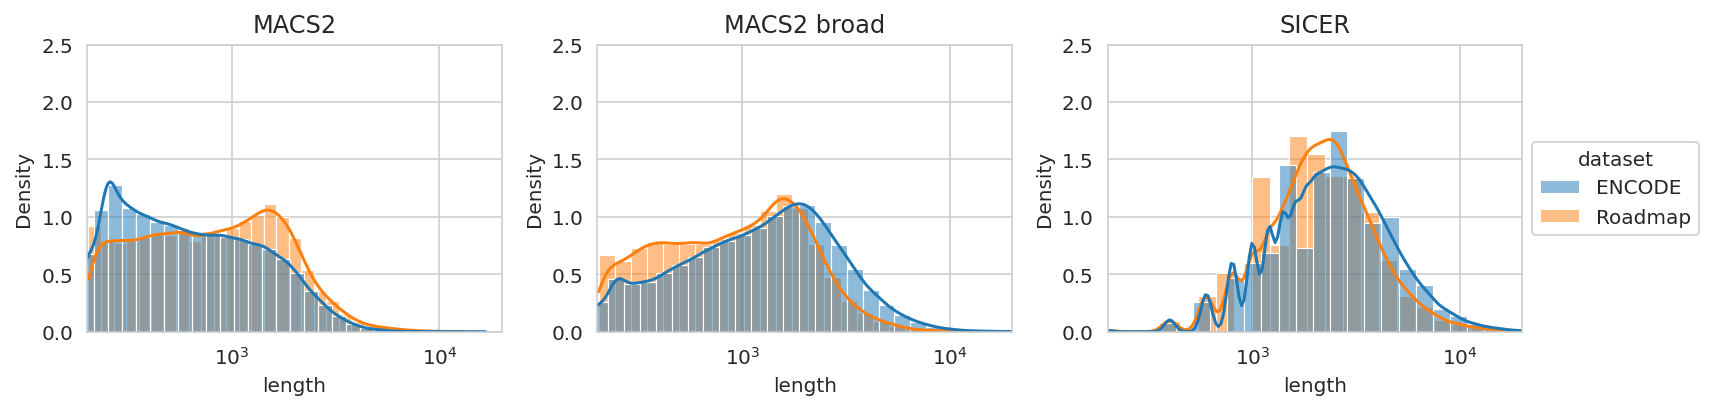

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


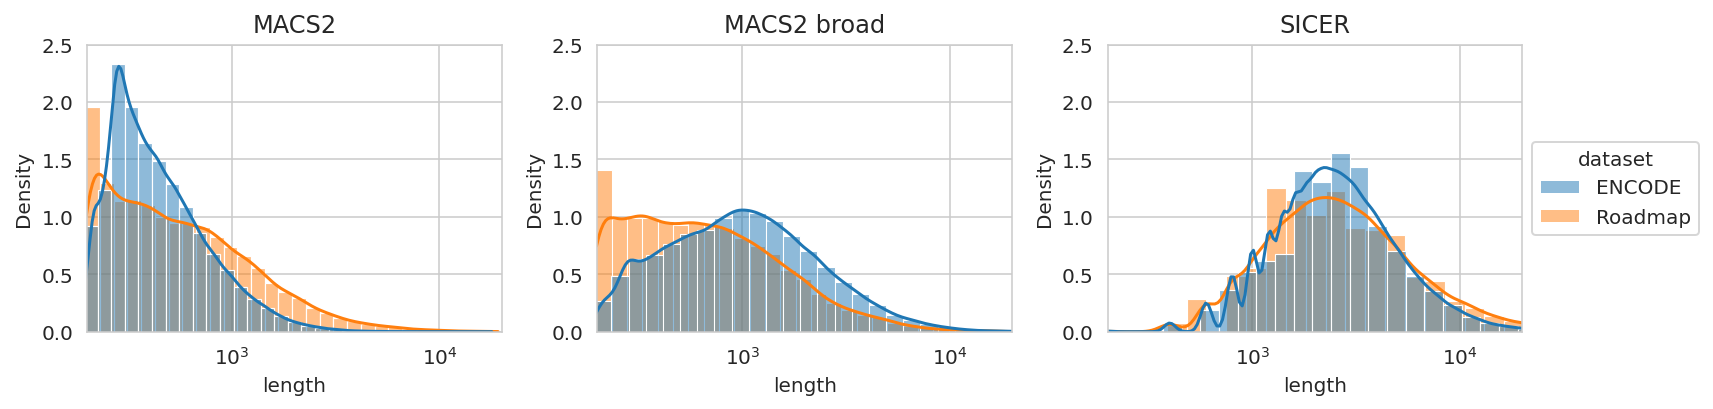

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


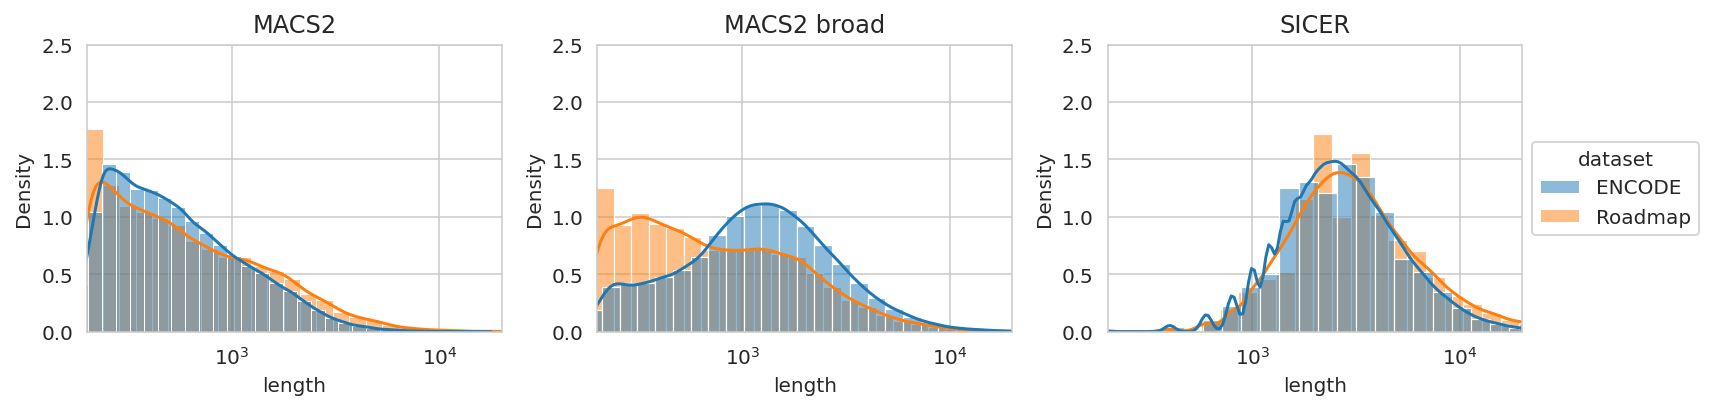

H3K36me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


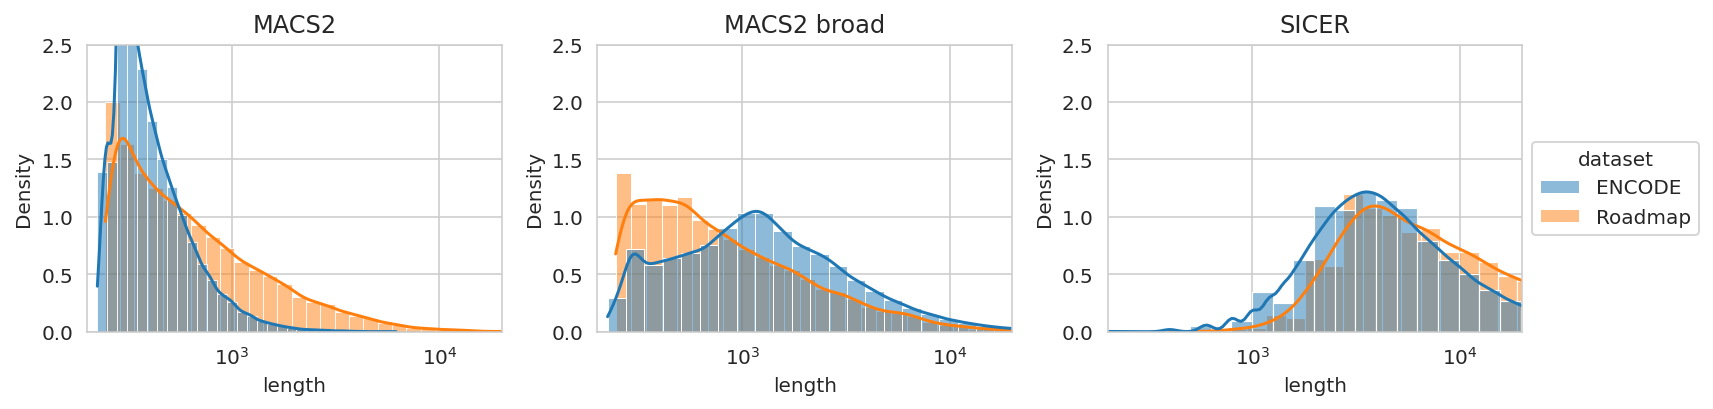

In [328]:
for m in ['H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='dataset', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 # palette=TOOLS_PALETTE,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K36me3


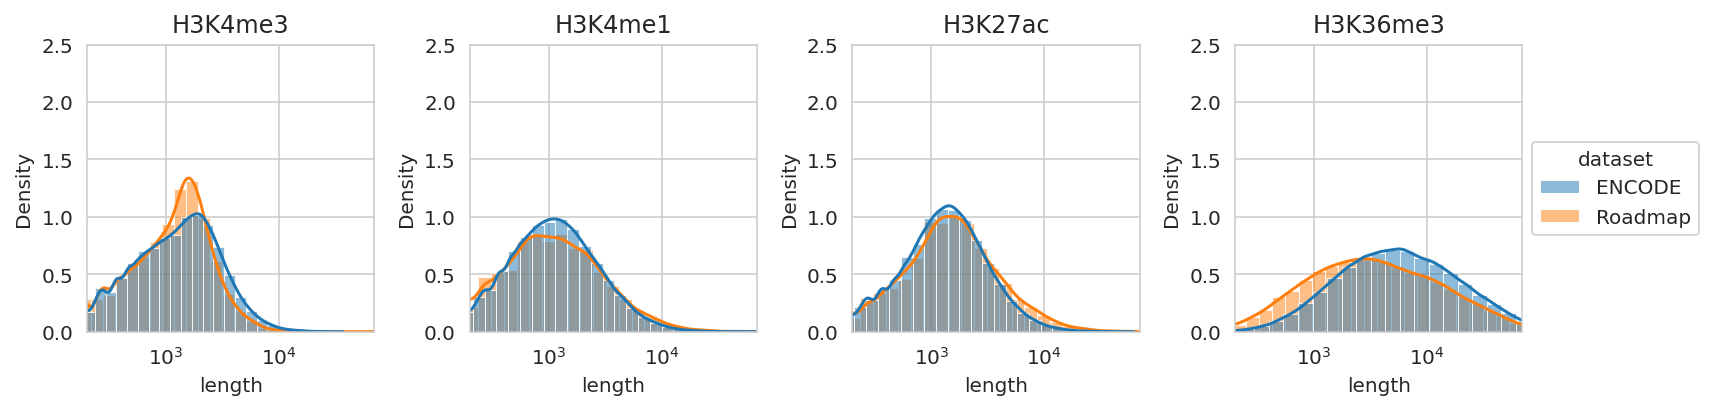

In [332]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # palette=TOOLS_PALETTE,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 7e4)
    ax.title.set_text(m)
    if i < 3:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

# Load downsampled peaks

In [18]:
# NOISE_PATH = os.path.expanduser('~/data/2023_Immune_noise')
NOISE_PATH = os.path.expanduser('~/data/2023_Immune_mln_control')

In [19]:
df_peaks_noise = load_peaks_path(NOISE_PATH, MODIFICATIONS, IMMUNE_CELLS, [''])
df_peaks_noise['quality'] = 0
for mln in [15, 10, 5, 2, 1]:
    df_peaks_noise.loc[[f'_{mln}mln' in file for file in df_peaks_noise['file']], 'quality'] = mln
df_peaks_noise.sample(3)

  0%|          | 0/352 [00:00<?, ?it/s]

MACS2 32


  0%|          | 0/352 [00:00<?, ?it/s]

MACS2 broad 32


  0%|          | 0/352 [00:00<?, ?it/s]

SICER 32


  0%|          | 0/45 [00:00<?, ?it/s]

SPAN 32


,file,modification,cell,replicate,peaks,tool,quality
2,/home/jetbrains/data/2023_Immune_mln_control/m...,H3K4me3,TCell,,14709,MACS2,1
122,/home/jetbrains/data/2023_Immune_mln_control/s...,H3K27ac,BCell,,17240,SPAN,5
16,/home/jetbrains/data/2023_Immune_mln_control/m...,H3K4me3,TCell,,25449,MACS2,5


In [61]:
t1 = df_peaks_noise[df_peaks_noise['quality'] == 10].copy()
t1['reads'] = 10
t2 = df_immune_peaks.copy()
t2['reads'] = 20
df_downsample = pd.concat([t1, t2]).reset_index(drop=True)
df_downsample['reads'] = df_downsample['reads'].astype(str) + 'M'

df_downsample

,file,modification,cell,replicate,peaks,tool,quality,reads,dataset
0,/home/jetbrains/data/2023_Immune_mln_control/m...,H3K4me1,BCell,,112650,MACS2,10.0,10M,NaN
1,/home/jetbrains/data/2023_Immune_mln_control/m...,H3K4me3,BCell,,23702,MACS2,10.0,10M,NaN
2,/home/jetbrains/data/2023_Immune_mln_control/m...,H3K4me3,TCell,,27685,MACS2,10.0,10M,NaN
3,/home/jetbrains/data/2023_Immune_mln_control/m...,H3K36me3,BCell,,137165,MACS2,10.0,10M,NaN
4,/home/jetbrains/data/2023_Immune_mln_control/m...,H3K4me1,TCell,,124685,MACS2,10.0,10M,NaN
...,...,...,...,...,...,...,...,...,...
67,/home/jetbrains/data/2023_Immune/span/TCell_H3...,H3K27me3,TCell,,222162,SPAN,NaN,20M,Roadmap
68,/home/jetbrains/data/2023_Immune/span/BCell_H3...,H3K36me3,BCell,,42693,SPAN,NaN,20M,Roadmap
69,/home/jetbrains/data/2023_Immune/span/BCell_H3...,H3K27ac,BCell,,26454,SPAN,NaN,20M,Roadmap
70,/home/jetbrains/data/2023_Immune/span/BCell_H3...,H3K4me1,BCell,,89375,SPAN,NaN,20M,Roadmap


H3K27ac
H3K4me1


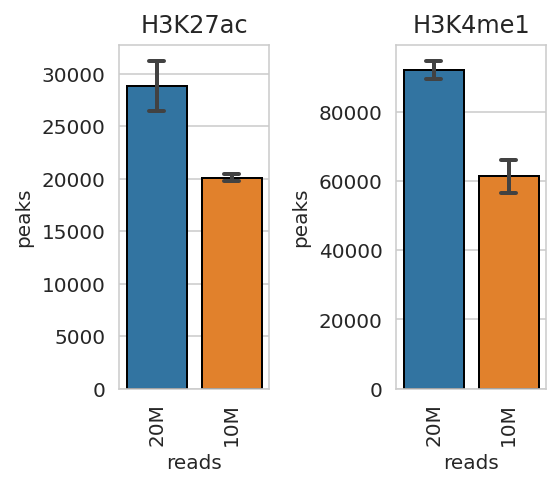

In [317]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=df_downsample[(df_downsample['modification'] == m) & (df_downsample['tool'] == 'SPAN')],
                            x='reads', y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['20M', '10M'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

MACS2
MACS2 broad
SICER


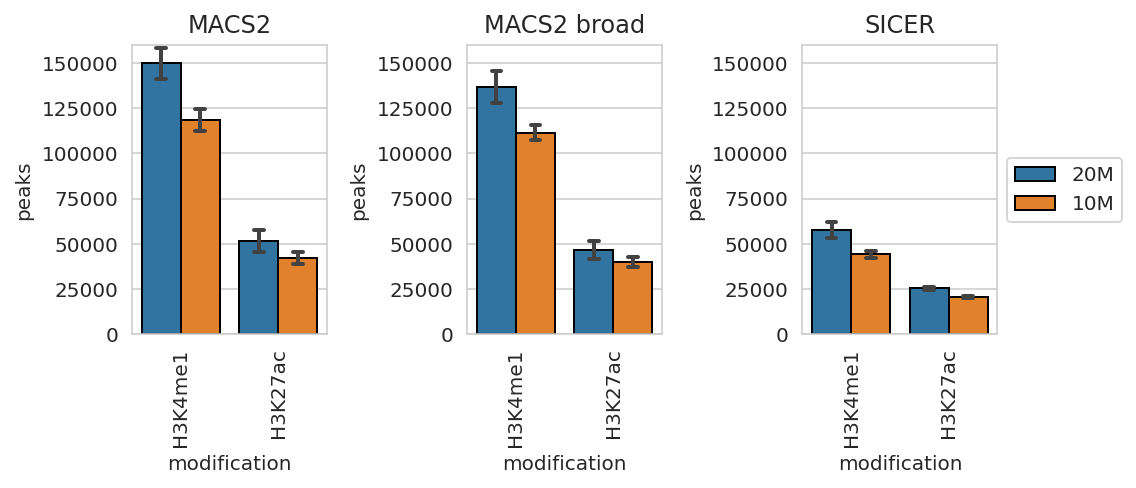

In [318]:
plt.figure(figsize=(8, 3.5))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    print(tool)
    ax = axs[i]
    g_results = sns.barplot(data=df_downsample[
        ((df_downsample['modification'] == 'H3K27ac') |
         (df_downsample['modification'] == 'H3K4me1')) & (df_downsample['tool'] == tool)],
                            hue='reads', x='modification', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            hue_order=['20M', '10M'],
                            )
    ax.set_ylim(0, 160_000)
    ax.set_title(tool)
    if i != 2:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


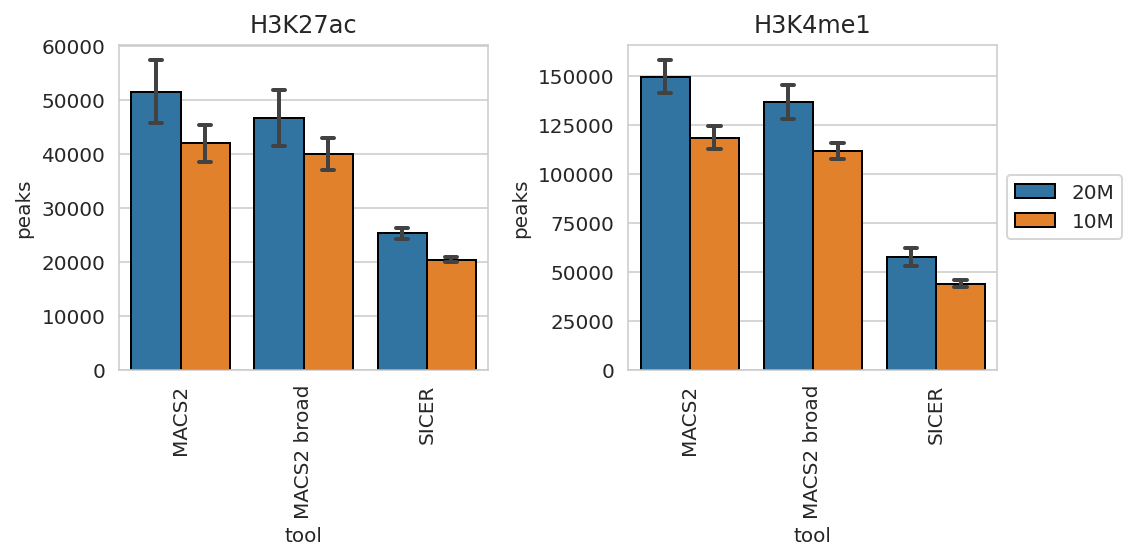

In [322]:
plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=df_downsample[df_downsample['modification'] == m],
                            hue='reads', x='tool', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            hue_order=['20M', '10M'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)
    if i != 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [304]:
print('Load lengths')
ts = []
for mod, signal_reads, file, tool in tqdm(zip(
        df_downsample['modification'], df_downsample['reads'], df_downsample['file'], df_downsample['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['modification'] = mod
    t['reads'] = signal_reads
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

,length,modification,reads,tool
286541,1159,H3K4me3,10M,SPAN
565646,999,H3K4me1,20M,SICER
307491,5086,H3K4me1,10M,SPAN
12964,239,H3K4me3,10M,MACS2
632735,19714,H3K36me3,20M,SPAN
308410,4865,H3K4me1,10M,SPAN
357849,802,H3K4me1,20M,MACS2
387100,245,H3K36me3,20M,MACS2
443060,2813,H3K27ac,20M,MACS2 broad
446508,823,H3K27ac,20M,MACS2 broad


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


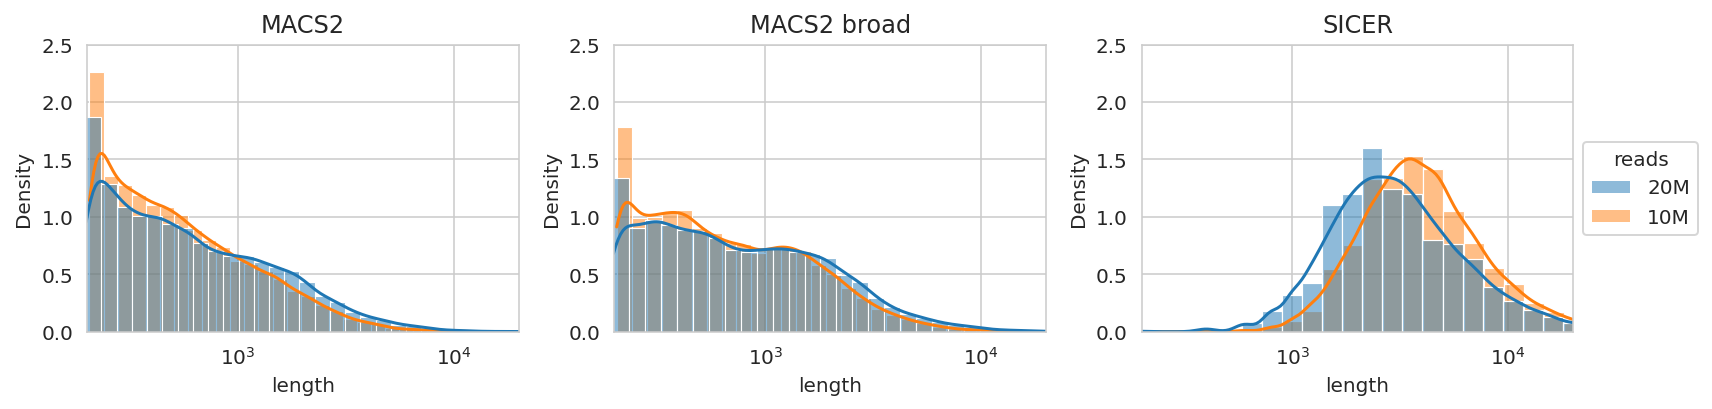

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


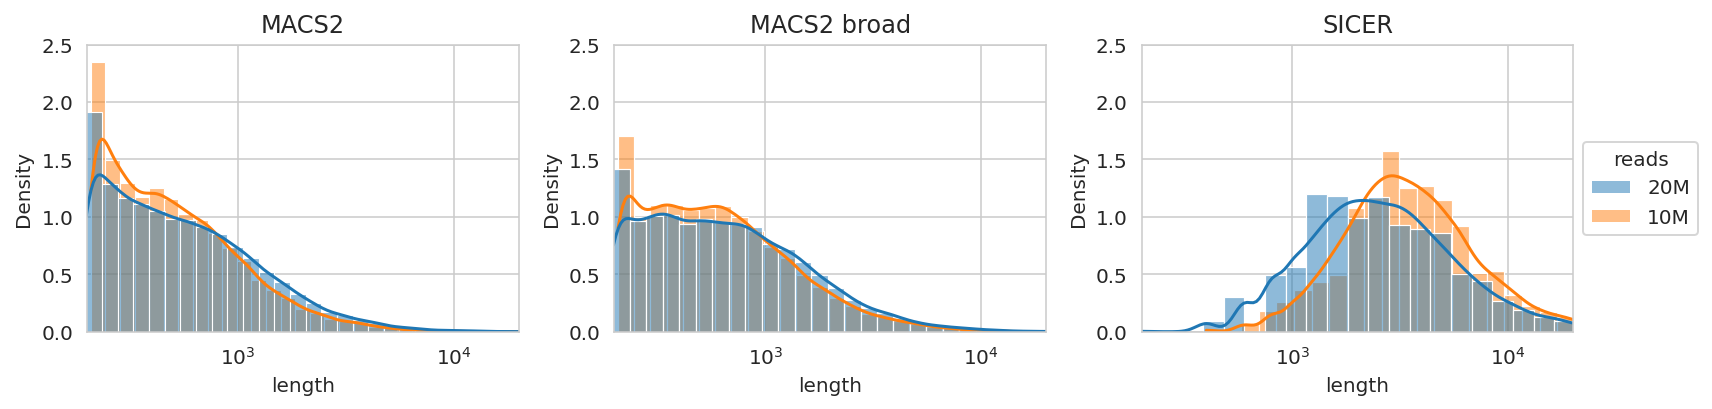

In [305]:
palette = plt.cm.get_cmap('tab10')
READS_PALETTE = {'20M': palette(0), '10M': palette(1)}

t['dataset'] = t['modification'] + ' ' + t['reads']

for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='reads', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 hue_order=['20M', '10M'],
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.tight_layout()
    plt.show()


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


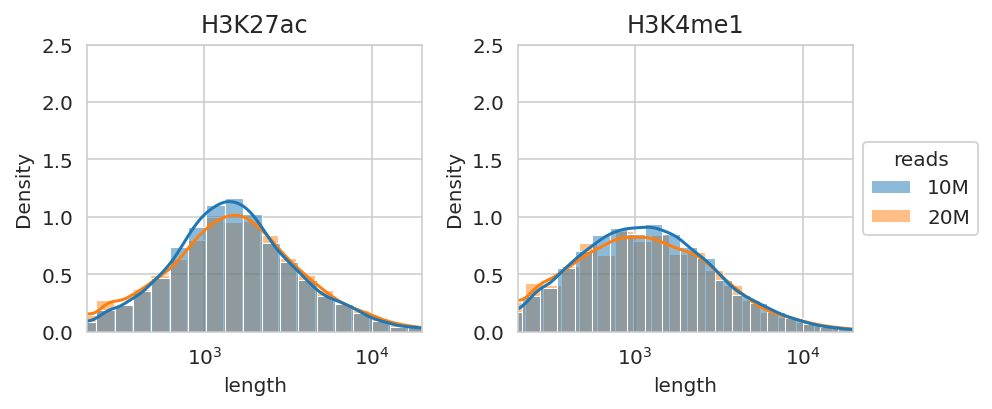

In [309]:
palette = plt.cm.get_cmap('tab10')
READS_PALETTE = {'20M': palette(0), '10M': palette(1)}

t['dataset'] = t['modification'] + ' ' + t['reads']

plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='reads', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # hue_order=['20M', '10M'],
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


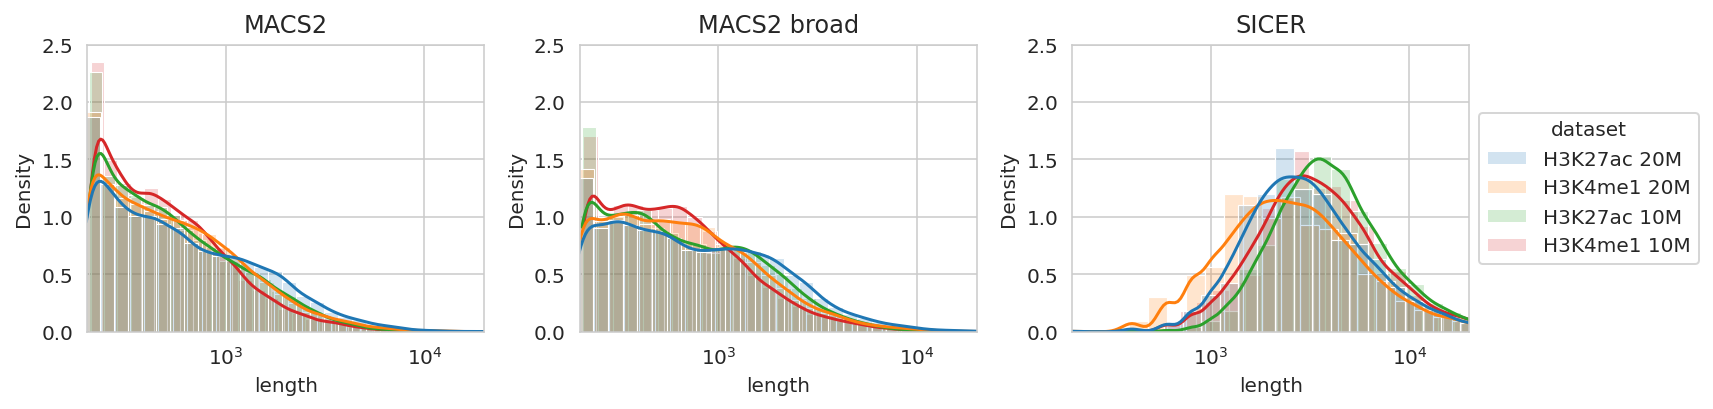

In [307]:
t['dataset'] = t['modification'] + ' ' + t['reads']

plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(
        data=t[((t['modification'] == 'H3K27ac') | (t['modification'] == 'H3K4me1')) & (t['tool'] == tool)],
        x='length', hue='dataset', ax=ax,
        stat='density', common_bins=False, common_norm=False,
        bins=30, kde=True, log_scale=True, alpha=0.2,
        hue_order=['H3K27ac 20M', 'H3K4me1 20M', 'H3K27ac 10M', 'H3K4me1 10M'],
        # palette=READS_PALETTE,
        )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 2:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


## Jaccard original vs downsampled

In [571]:
df_downsample

,file,modification,cell,replicate,peaks,tool,quality,reads,dataset
0,/home/jetbrains/data/2023_Immune_mln_control/m...,H3K4me1,BCell,,112650,MACS2,10.0,10M,NaN
1,/home/jetbrains/data/2023_Immune_mln_control/m...,H3K4me3,BCell,,23702,MACS2,10.0,10M,NaN
2,/home/jetbrains/data/2023_Immune_mln_control/m...,H3K4me3,TCell,,27685,MACS2,10.0,10M,NaN
3,/home/jetbrains/data/2023_Immune_mln_control/m...,H3K36me3,BCell,,137165,MACS2,10.0,10M,NaN
4,/home/jetbrains/data/2023_Immune_mln_control/m...,H3K4me1,TCell,,124685,MACS2,10.0,10M,NaN
...,...,...,...,...,...,...,...,...,...
67,/home/jetbrains/data/2023_Immune/span/TCell_H3...,H3K27me3,TCell,,222162,SPAN,NaN,20M,Roadmap
68,/home/jetbrains/data/2023_Immune/span/BCell_H3...,H3K36me3,BCell,,42693,SPAN,NaN,20M,Roadmap
69,/home/jetbrains/data/2023_Immune/span/BCell_H3...,H3K27ac,BCell,,26454,SPAN,NaN,20M,Roadmap
70,/home/jetbrains/data/2023_Immune/span/BCell_H3...,H3K4me1,BCell,,89375,SPAN,NaN,20M,Roadmap


In [574]:
bench_df = pd.DataFrame(
    columns=['modification', 'cell', 'replicate', 'name', 'quality',
             'original_peaks', 'original_peaks_len',
             'peaks', 'peaks_len', 'overlap1', 'overlap2', 'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for m, c, r, tool in tqdm(product(['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, [''], TOOLS)):
    print(m, c, r, tool)
    t = df_downsample[
        (df_downsample['modification'] == m) &
        (df_downsample['cell'] == c) &
        (df_downsample['replicate'] == r) &
        (df_downsample['tool'] == tool) &
        (df_downsample['reads'] == '20M')]
    if len(t) == 0:
        print('-')
        continue
    original_file = sorted_file(t['file'].values[0])
    original_peaks = lines(original_file)
    original_peaks_len = int(bedl(original_file).sum())
    t = df_downsample[
        (df_downsample['modification'] == m) &
        (df_downsample['cell'] == c) &
        (df_downsample['replicate'] == r) &
        (df_downsample['tool'] == tool) &
        (df_downsample['reads'] == '10M')]
    if len(t) == 0:
        continue
    file = sorted_file(t['file'].values[0])
    peaks = lines(file)
    peaks_len = int(bedl(file).sum())
    !bedtools intersect -a {original_file} -b {file} -wa -u > {tf}
    overlap1 = lines(tf)
    !bedtools intersect -b {original_file} -a {file} -wa -u > {tf}
    overlap2 = lines(tf)
    !bedtools intersect -a {original_file} -b {file} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    bench_df.loc[len(bench_df)] = \
        (m, c, r, tool, '10M',
         original_peaks, original_peaks_len,
         peaks, peaks_len, overlap1, overlap2, overlap_len)

display(bench_df.sample(3))


0it [00:00, ?it/s]

H3K27ac BCell  MACS2
H3K27ac BCell  MACS2 broad
H3K27ac BCell  SPAN
H3K27ac BCell  SICER
H3K27ac TCell  MACS2
H3K27ac TCell  MACS2 broad
H3K27ac TCell  SPAN
H3K27ac TCell  SICER
H3K4me1 BCell  MACS2
H3K4me1 BCell  MACS2 broad
H3K4me1 BCell  SPAN
H3K4me1 BCell  SICER
H3K4me1 TCell  MACS2
H3K4me1 TCell  MACS2 broad
H3K4me1 TCell  SPAN
H3K4me1 TCell  SICER


,modification,cell,replicate,name,quality,original_peaks,original_peaks_len,peaks,peaks_len,overlap1,overlap2,overlap_len
1,H3K27ac,BCell,,MACS2 broad,10M,41460,46789660,37017,36345943,30175,35461,35246812
3,H3K27ac,BCell,,SICER,10M,24342,91201858,19973,96053627,20364,19794,79403227
15,H3K4me1,TCell,,SICER,10M,53056,219629344,42196,211275604,42849,41982,189220709


In [576]:
bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['original_peaks_len'], bench_df['peaks_len'], bench_df['overlap_len'])
]
bench_df.sample(1)


,modification,cell,replicate,name,quality,original_peaks,original_peaks_len,peaks,peaks_len,overlap1,overlap2,overlap_len,jaccard
9,H3K4me1,BCell,,MACS2 broad,10M,127965,141202454,107461,99905329,87816,105096,97527225,0.679251


H3K27ac
H3K4me1


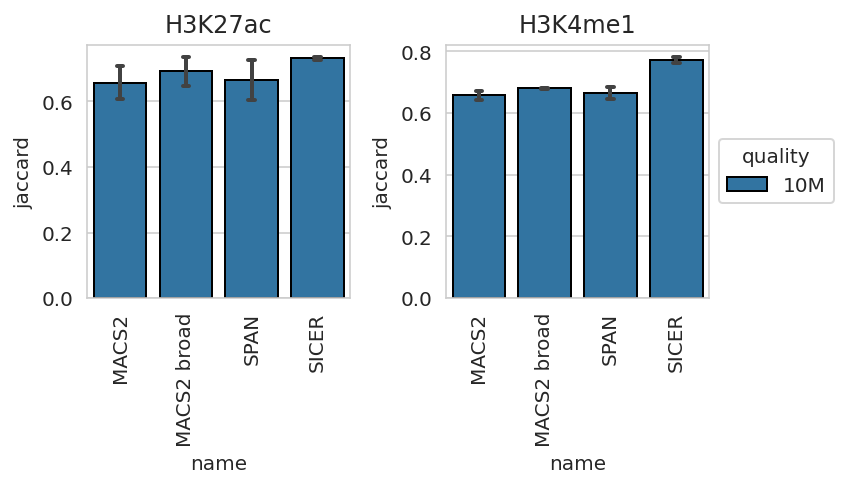

In [577]:
plt.figure(figsize=(6, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=bench_df[bench_df['modification'] == m],
                            x='name', hue='quality', y='jaccard', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            # hue_order=['wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

## Compute BAM coverage

In [90]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams


In [91]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_encode_bams.sample(3)

  0%|          | 0/206 [00:00<?, ?it/s]

,bam_file,modification,cell,replicate,reads,dataset
26,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,HepG2,rep1,7474026,ENCODE
0,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K36me3,NHLF,rep1,14385159,ENCODE
58,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,K562,rep1,11704712,ENCODE


In [92]:
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, [''], 'Control')
df_immune_bams['dataset'] = 'Roadmap'
df_immune_bams.sample(3)

  0%|          | 0/35 [00:00<?, ?it/s]

,bam_file,modification,cell,replicate,reads,dataset
8,/home/jetbrains/data/2023_Immune/bams/TCell_H3...,H3K27me3,TCell,,25580386,Roadmap
10,/home/jetbrains/data/2023_Immune/bams/TCell_H3...,H3K27ac,TCell,,30425955,Roadmap
4,/home/jetbrains/data/2023_Immune/bams/BCell_H3...,H3K36me3,BCell,,22597809,Roadmap


In [93]:
df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)

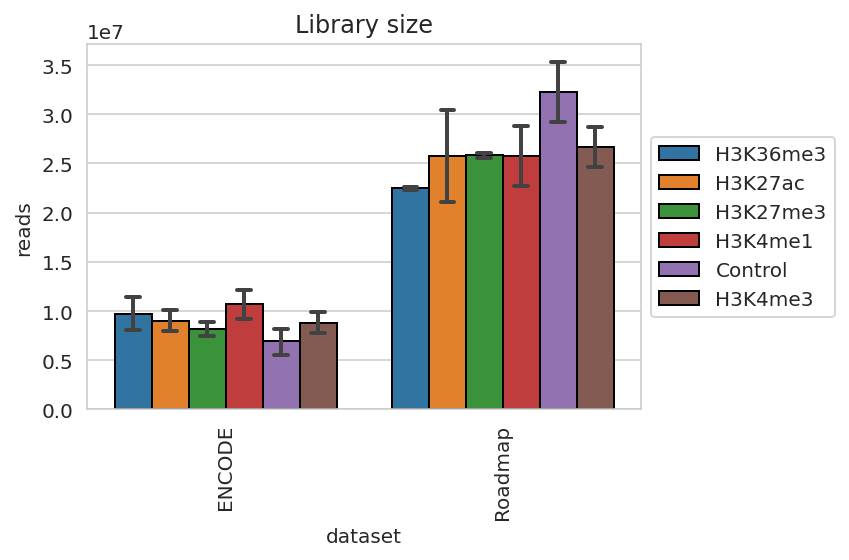

In [97]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams,
                        hue='modification', x='dataset', y='reads', ax=ax,
                        capsize=.05, errwidth=2, edgecolor="black",
                        )
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

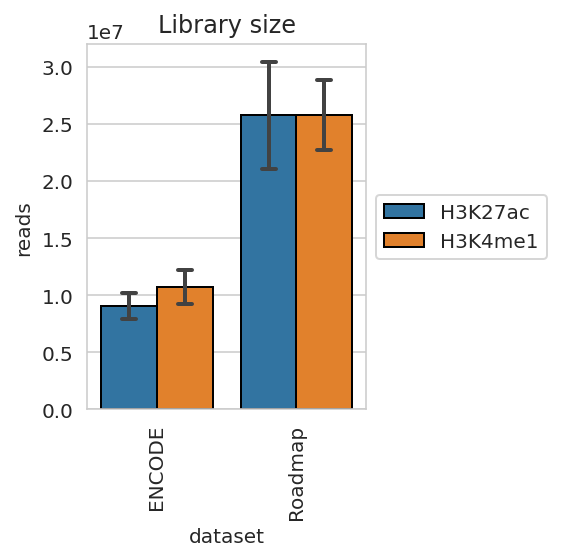

In [95]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams[(df_bams['modification'] == 'H3K27ac') | (df_bams['modification'] == 'H3K4me1')],
                        hue='modification', x='dataset', y='reads', ax=ax,
                        capsize=.1, errwidth=2, edgecolor="black",
                        )
# ax.set_ylim(0, 160_000)
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Prepare datasets with wiggling and mixing control data into signal track

In [358]:
# Prepare bed files

WD = os.path.expanduser('~/data/2023_GSE26320_wiggle_mix')
! mkdir -p {WD}/bed

df_bam_beds = df_bams[(df_bams['modification'].isin(['H3K27ac', 'H3K4me1', 'Control'])) & 
                      (~df_bams['cell'].isin(['H1'])) & 
                      (df_bams['replicate'] == 'rep1') &
                      (df_bams['dataset'] == 'ENCODE')].copy()
df_bam_beds.sample(3)

,bam_file,modification,cell,replicate,reads,dataset
14,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,HSMM,rep1,8080332,ENCODE
5,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,K562,rep1,10381382,ENCODE
49,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,NHEK,rep1,8094298,ENCODE


In [359]:
beds = []
for _, (bam_file, m, c, r, _, _) in df_bam_beds.iterrows():
    bed_file = f'{WD}/bed/{os.path.basename(bam_file).replace(".bam", ".bed")}'
    print(bed_file)
    beds.append(bed_file)
    if not os.path.exists(bed_file):
        ! bamToBed -i {bam_file} > {bed_file}
df_bam_beds['bed_file'] = beds
df_bam_beds.sample(3)

/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646456_NHEK_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646452_K562_Input_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646390_HMEC_Input_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646374_HMEC_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646322_GM12878_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646400_HSMM_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646380_HMEC_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646414_Huvec_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646492_NHLF_Input_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646355_HepG2_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646476_NHLF_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646394_HSMM_H3K27ac_rep1.bed
/home/jetbrains/d

,bam_file,modification,cell,replicate,reads,dataset,bed_file
16,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,HMEC,rep1,16351916,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...
72,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,GM12878,rep1,7049058,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...
10,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,HMEC,rep1,3750119,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...


## Wiggle

In [365]:
tf1 = tempfile.mktemp()
tf2 = tempfile.mktemp()
tf3 = tempfile.mktemp()
tf4 = tempfile.mktemp()

wiggles = []
for _, row in tqdm(df_bam_beds.iterrows()):
    bam_file, m, c, r, bed_file = row['bam_file'], row['modification'], row['cell'], row['replicate'], row['bed_file']
    print('Wiggle', m, c, r, bed_file)
    if m == 'Control':
        wiggles.append(None)
        ! ln -sf {bam_file} {WD}/bams/{os.path.basename(bam_file)} 
        continue
    result_file = f'{WD}/bams/{m}_{c}_{r}_wiggle.bam'
    wiggles.append(result_file)
    print(result_file)
    if os.path.exists(result_file):
        continue
    t = pd.read_csv(bed_file, sep='\t', header=None)
    print('Reads', len(t))
    signal = t.sample(int(len(t) * 0.8))
    noise = t.sample(int(len(t) * 0.2))
    delta = [int(x) for x in np.random.normal(0, 5_000, size=len(noise))]
    noise[1] += delta
    noise[2] += delta
    # Ensure generated reads have proper coordinates
    noise.loc[noise[1] < 1, 1] = 1
    noise.loc[noise[2] < 1, 2] = 1
    signal.to_csv(tf1, sep='\t', index=False, header=None)
    noise.to_csv(tf2, sep='\t', index=False, header=None)
    del t, signal, noise, delta
    ! cat {tf1} > {tf3}
    ! cat {tf2} >> {tf3}
    ! rm {tf1} {tf2}
    ! cat {tf3} | sort -k1,1 -k2,2n -k3,3n > {tf4}
    ! rm {tf3}
    ! bedToBam -i {tf4} -g {WD}/hg38.chrom.sizes > {result_file}
    ! rm {tf4}
    print('Done')
df_bam_beds['wiggle'] = wiggles
df_bam_beds.sample(3)

0it [00:00, ?it/s]

Wiggle H3K27ac NHEK rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646456_NHEK_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_NHEK_rep1_wiggle.bam
Wiggle Control K562 rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646452_K562_Input_rep1.bed
Wiggle Control HMEC rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646390_HMEC_Input_rep1.bed
Wiggle H3K27ac HMEC rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646374_HMEC_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_HMEC_rep1_wiggle.bam
Wiggle H3K4me1 GM12878 rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646322_GM12878_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K4me1_GM12878_rep1_wiggle.bam
Wiggle H3K4me1 HSMM rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646400_HSMM_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K4me1_HSMM_rep1_wiggle.bam
Wiggle H3K4me1 HMEC rep1 /home/je

,bam_file,modification,cell,replicate,reads,dataset,bed_file,wiggle
16,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,HMEC,rep1,16351916,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...
53,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,HepG2,rep1,9110760,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,None
23,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,NHLF,rep1,3235572,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,None


## Mix control

In [453]:
df_bam_beds

,bam_file,modification,cell,replicate,reads,dataset,bed_file,wiggle,mix
2,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,NHEK,rep1,9377615,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...
5,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,K562,rep1,10381382,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,None,None
10,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,HMEC,rep1,3750119,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,None,None
12,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,HMEC,rep1,10940745,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...
13,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,GM12878,rep1,11008158,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...
14,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,HSMM,rep1,8080332,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...
16,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,HMEC,rep1,16351916,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...
17,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,Huvec,rep1,12283487,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...
23,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,NHLF,rep1,3235572,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,None,None
26,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,HepG2,rep1,7474026,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...


In [514]:
mixtures = []
for _, row in tqdm(df_bam_beds.iterrows()):
    bam_file, m, c, r, bed_file = row['bam_file'], row['modification'], row['cell'], row['replicate'], row['bed_file']
    if m == 'Control':
        mixtures.append(None)
        continue
    print('Mix', m, c, r)
    result_file = f'{WD}/bams/{m}_{c}_{r}_mix.bam'
    mixtures.append(result_file)
    print(result_file)
    if os.path.exists(result_file):
        continue
    control_file = df_bam_beds[(df_bam_beds['cell'] == c) & 
                               (df_bam_beds['replicate'] == r) & 
                               (df_bam_beds['modification'] == 'Control')]['bed_file'].values[0]
    signal = pd.read_csv(bed_file, sep='\t', header=None)
    noise = pd.read_csv(control_file, sep='\t', header=None)
    signal_reads = len(signal)
    control_reads = len(noise)
    print('Signal', bed_file, signal_reads)
    print('Control', control_file, control_reads)
    signal = signal.sample(int(signal_reads * 0.5))
    noise = noise.sample(min(signal_reads, int(control_reads * 0.5)))
    signal.to_csv(tf1, sep='\t', index=False, header=None)
    noise.to_csv(tf2, sep='\t', index=False, header=None)
    ! cat {tf1} > {tf3}
    ! cat {tf2} >> {tf3}
    ! rm {tf1} {tf2}
    ! cat {tf3} | sort -k1,1 -k2,2n -k3,3n > {tf4}
    ! rm {tf3}
    ! bedToBam -i {tf4} -g {WD}/hg38.chrom.sizes > {result_file}
    ! rm {tf4}
    del signal, noise
    print('Done')

df_bam_beds['mix'] = mixtures 
df_bam_beds.sample(3)

0it [00:00, ?it/s]

Mix H3K27ac NHEK rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_NHEK_rep1_mix.bam
Signal /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646456_NHEK_H3K27ac_rep1.bed 9377615
Control /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646472_NHEK_Input_rep1.bed 8094298
Done
Mix H3K27ac HMEC rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_HMEC_rep1_mix.bam
Signal /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646374_HMEC_H3K27ac_rep1.bed 10940745
Control /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646390_HMEC_Input_rep1.bed 3750119
Done
Mix H3K4me1 GM12878 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K4me1_GM12878_rep1_mix.bam
Signal /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646322_GM12878_H3K4me1_rep1.bed 11008158
Control /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646332_GM12878_Input_rep1.bed 5699825
Done
Mix H3K4me1 HSMM rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K4me1_HSMM_rep1_mix.

,bam_file,modification,cell,replicate,reads,dataset,bed_file,wiggle,mix
98,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,GM12878,rep1,5699825,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,None,None
5,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,K562,rep1,10381382,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,None,None
55,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,K562,rep1,9537695,ENCODE,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...


# Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=True sicer=True --rerun-incomplete && \
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-incomplete;

```

In [515]:
df_peaks['name'] = df_peaks['tool']
df_peaks['type'] = 'original'

In [516]:
wiggle_mix_peaks = load_peaks_path(WD, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS) 
wiggle_mix_peaks['name'] = wiggle_mix_peaks['tool']
wiggle_mix_peaks['type'] = 'base'

mix_rows = ['mix' in os.path.basename(f) for f in wiggle_mix_peaks['file']]
wiggle_rows = ['wiggle' in os.path.basename(f) for f in wiggle_mix_peaks['file']]
wiggle_mix_peaks.loc[mix_rows, 'name'] = wiggle_mix_peaks[mix_rows]['name'] + ' mix'
wiggle_mix_peaks.loc[mix_rows, 'type'] = 'mix'
wiggle_mix_peaks.loc[wiggle_rows, 'name'] = wiggle_mix_peaks[wiggle_rows]['name'] + ' wiggle'
wiggle_mix_peaks.loc[wiggle_rows, 'type'] = 'wiggle'

wiggle_mix_peaks.sample(3)

  0%|          | 0/256 [00:00<?, ?it/s]

MACS2 32


  0%|          | 0/256 [00:00<?, ?it/s]

MACS2 broad 32


  0%|          | 0/32 [00:00<?, ?it/s]

SICER 32


  0%|          | 0/35 [00:00<?, ?it/s]

SPAN 32


,file,modification,cell,replicate,peaks,tool,name,type
41,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K4me1,K562,rep1,107146,MACS2 broad,MACS2 broad wiggle,wiggle
42,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,HepG2,rep1,59178,MACS2 broad,MACS2 broad wiggle,wiggle
126,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,HMEC,rep1,41809,SPAN,SPAN wiggle,wiggle


In [517]:
all_wiggle_mix_peaks = pd.concat([df_peaks[(df_peaks['dataset'] != 'Roadmap') & df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])], wiggle_mix_peaks]).reset_index(drop=True)
all_wiggle_mix_peaks.sample(3)

,file,modification,cell,replicate,peaks,tool,dataset,name,type
215,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,NHLF,rep1,34163,SICER,NaN,SICER wiggle,wiggle
61,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,GM12878,rep2,28199,MACS2 broad,ENCODE,MACS2 broad,original
113,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,H1,rep1,27529,SPAN,ENCODE,SPAN,original


MACS2
MACS2 broad
SICER


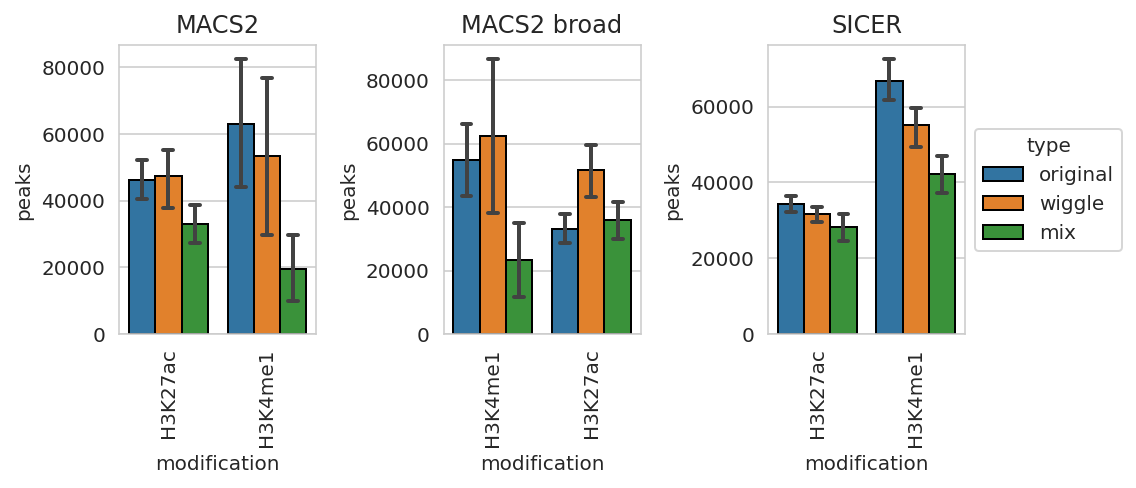

In [518]:
plt.figure(figsize=(8, 3.5))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]


for i, ty in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    print(ty)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[all_wiggle_mix_peaks['tool'] == ty],
                            x='modification', hue='type', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            hue_order=['original', 'wiggle', 'mix']
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(ty)
    if i < 2:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


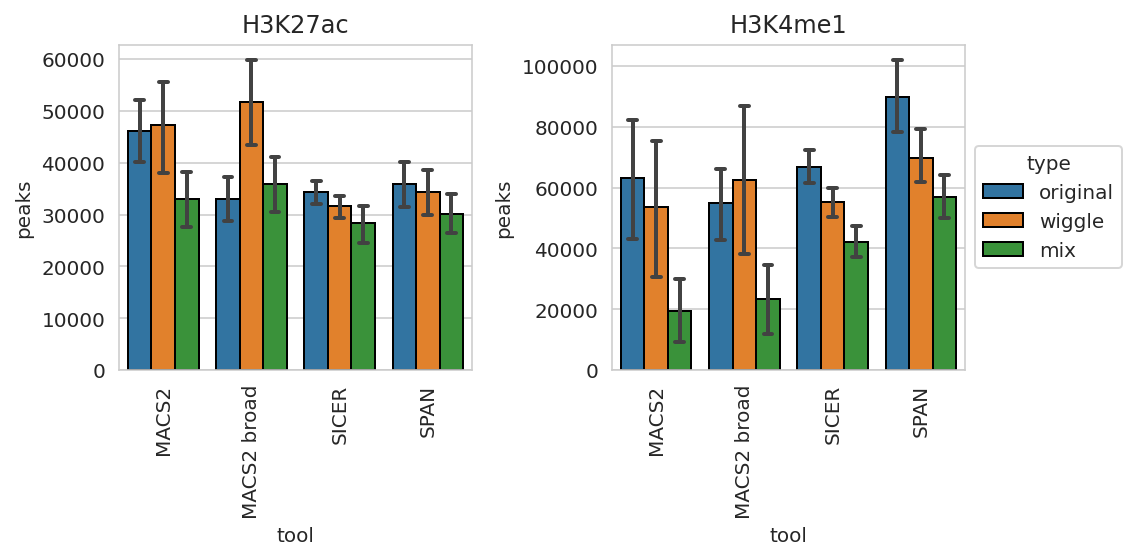

In [519]:
plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]


for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[all_wiggle_mix_peaks['modification'] == m],
                            x='tool', hue='type', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                            hue_order=['original', 'wiggle', 'mix']
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


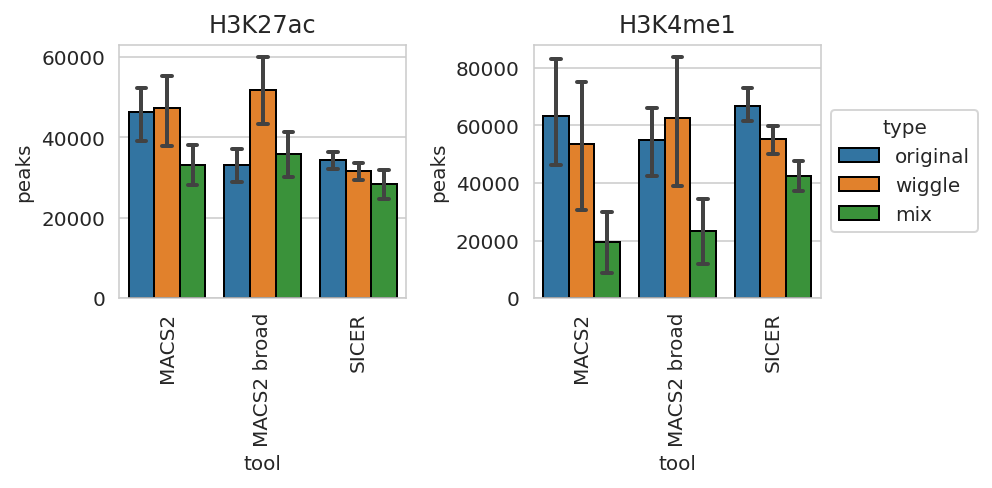

In [520]:
plt.figure(figsize=(7, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]


for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[all_wiggle_mix_peaks['modification'] == m],
                            x='tool', hue='type', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            hue_order=['original', 'wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

wiggle
H3K27ac
H3K4me1


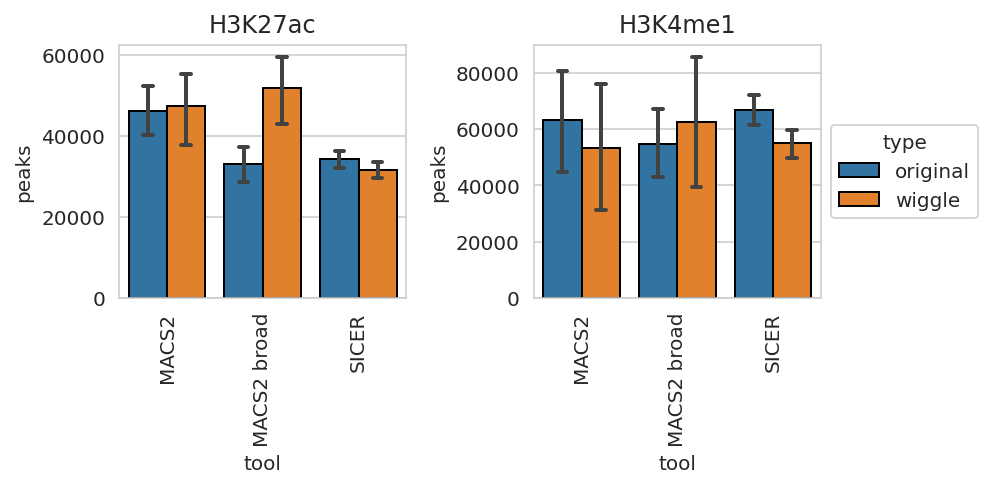

mix
H3K27ac
H3K4me1


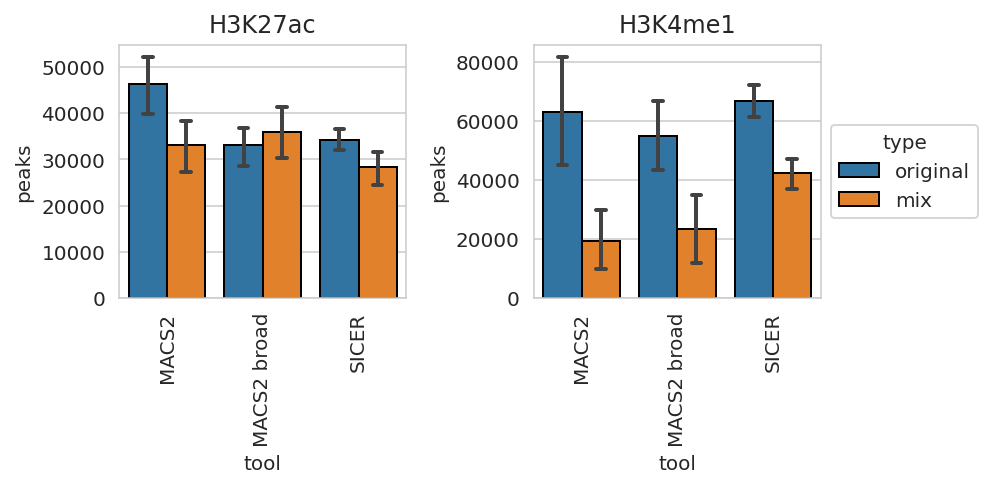

In [521]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(7, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) & (all_wiggle_mix_peaks['type'].isin(['original', ty]))],
                                x='tool', hue='type', y='peaks', ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                hue_order=['original', ty],
                                # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

H3K27ac
H3K4me1


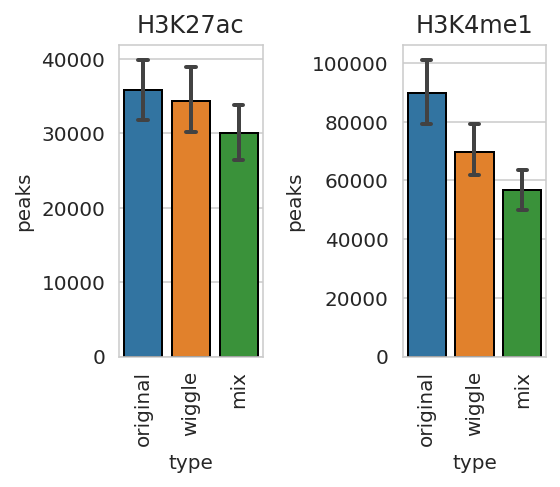

In [522]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) & (all_wiggle_mix_peaks['tool'] == 'SPAN')],
                            x='type',  y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['original', 'wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


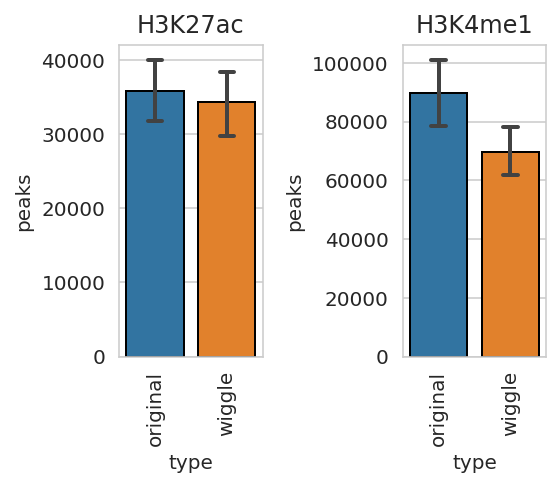

In [564]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) &
                                                      (all_wiggle_mix_peaks['tool'] == 'SPAN') &
                                                      (all_wiggle_mix_peaks['type'].isin(['original', 'wiggle']))],
                            x='type',  y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['original', 'wiggle'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [565]:
print('Load lengths')
ts = []
for mod, ty, file, tool in tqdm(zip(
        all_wiggle_mix_peaks['modification'], all_wiggle_mix_peaks['type'], all_wiggle_mix_peaks['file'], all_wiggle_mix_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['modification'] = mod
    t['type'] = ty
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

,length,modification,type,tool
843880,1799,H3K27ac,original,SICER
2078265,3399,H3K27ac,wiggle,SICER
1752441,645,H3K4me1,mix,MACS2 broad
173237,309,H3K27ac,original,MACS2
2311859,224,H3K27ac,wiggle,SPAN
1157143,10403,H3K4me1,original,SPAN
1355833,386,H3K4me1,mix,MACS2
2196444,7999,H3K4me1,mix,SICER
2251587,827,H3K4me1,mix,SPAN
1019057,1510,H3K27ac,original,SPAN


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


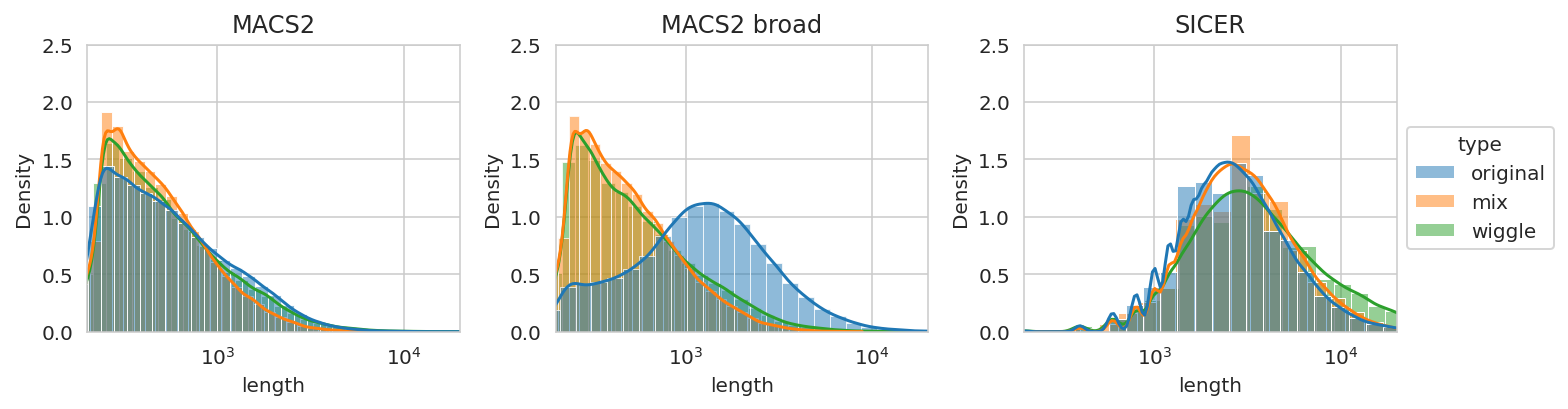

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


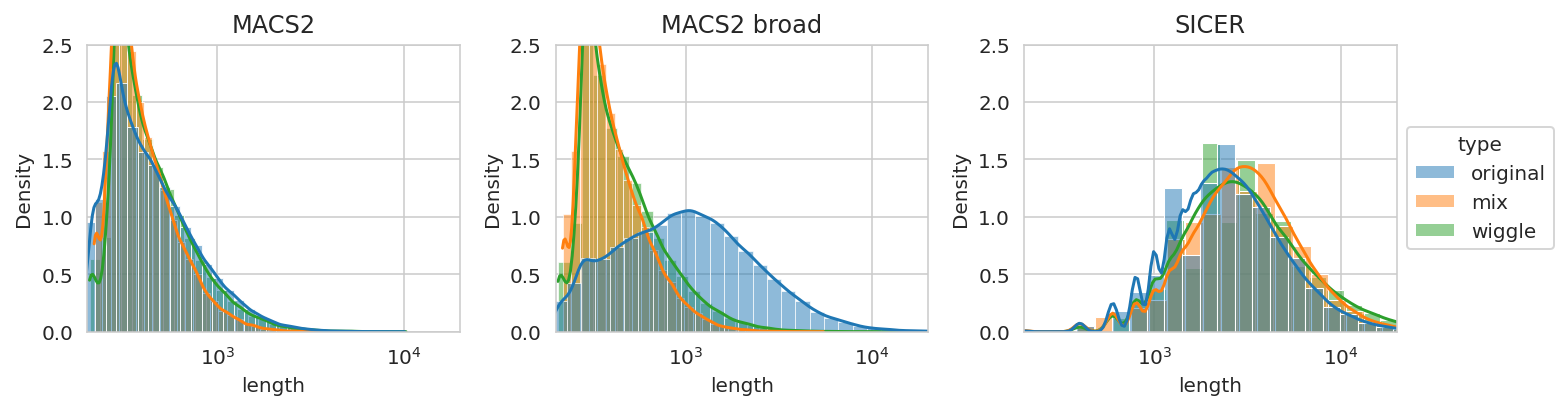

In [566]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(11, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='type', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.tight_layout()
    plt.show()


wiggle
H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


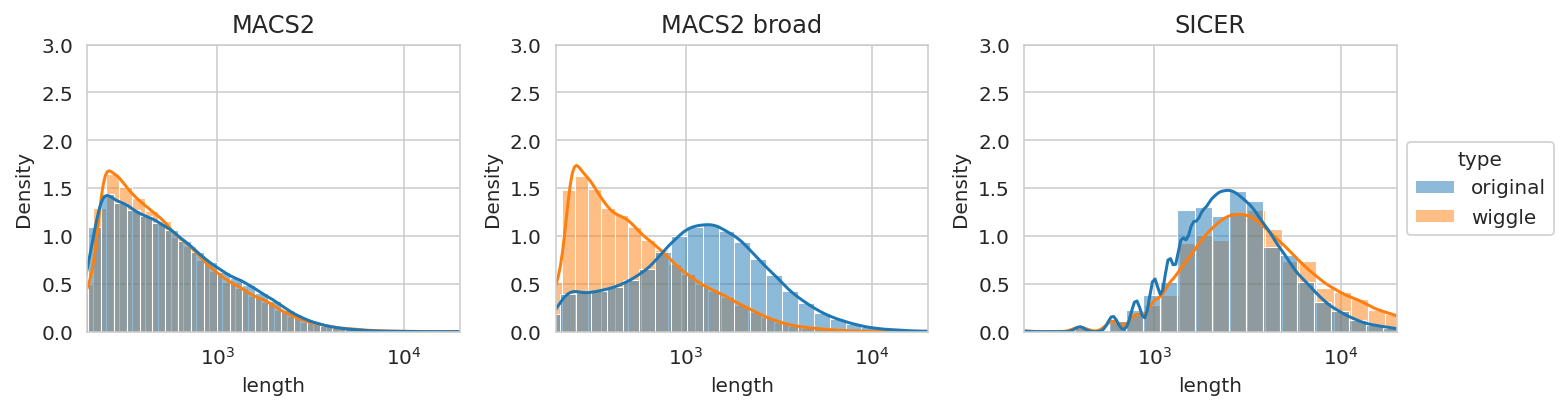

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


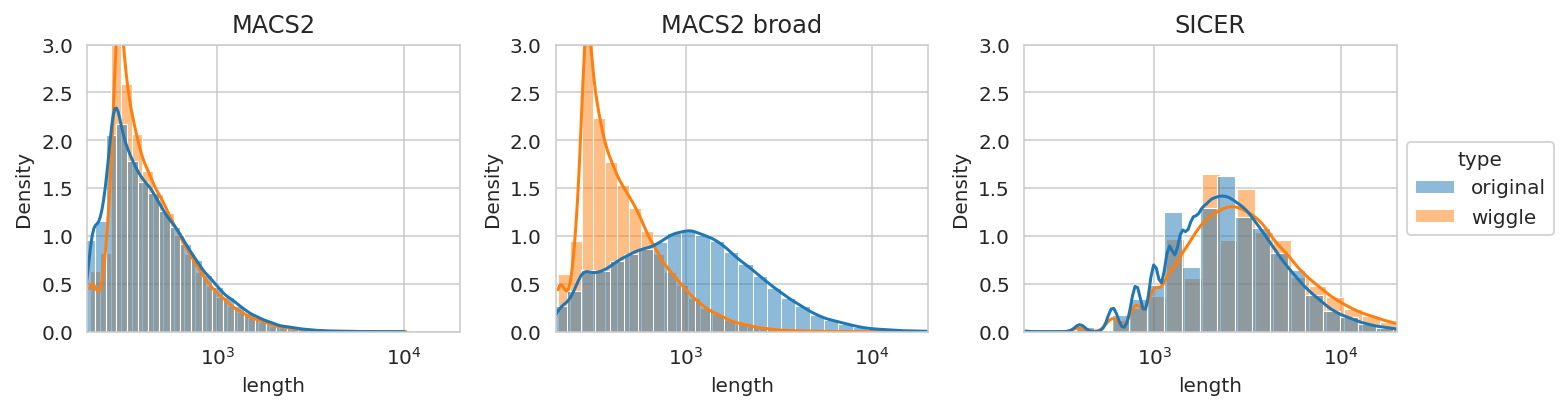

mix
H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


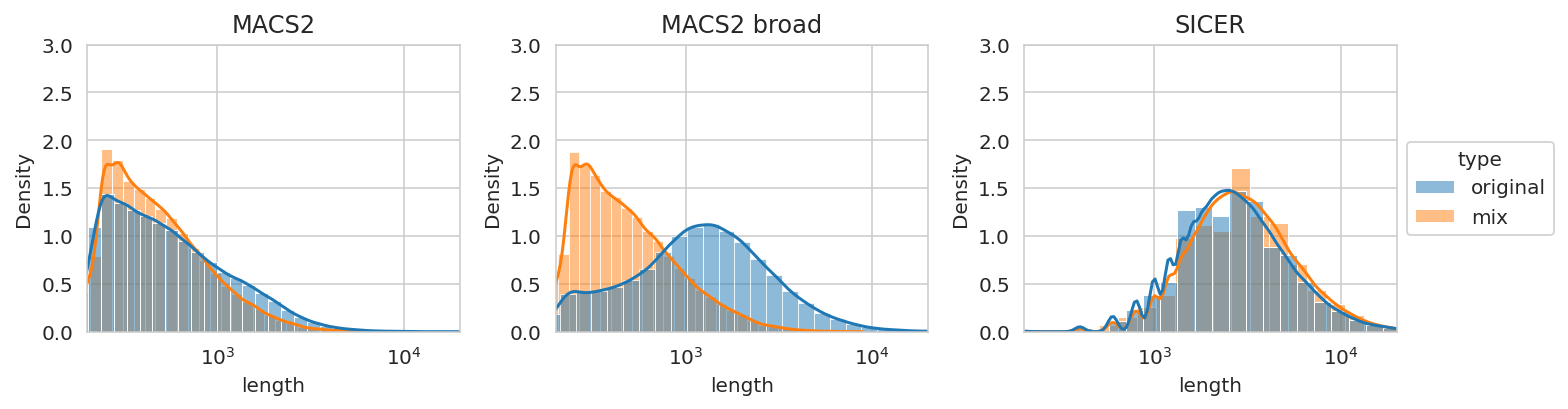

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


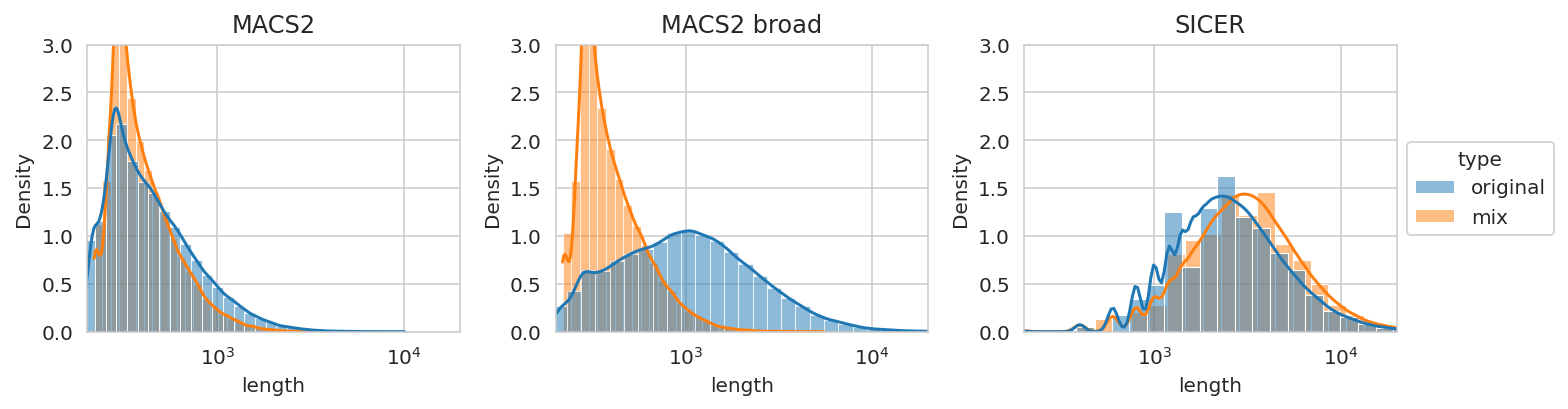

In [567]:
for ty in ['wiggle', 'mix']:
    print(ty)
    for m in ['H3K27ac', 'H3K4me1']:
        print(m)
        plt.figure(figsize=(11, 3))
        axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
        for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
            ax = axs[i]
            g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool) & (t['type'].isin(['original', ty]))],
                                     x='length', hue='type', ax=ax,
                                     stat='density', common_bins=False, common_norm=False,
                                     bins=30, kde=True, log_scale=True, alpha=0.5,
                                     )
            g_results.set(xscale='log')
            g_results.set_ylim(0, 3)
            g_results.set_xlim(200, 2e4)
            ax.title.set_text(f'{tool}')
            if i < 2:
                ax.legend().set_visible(False)
            else:
                sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

        plt.tight_layout()
        plt.show()

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


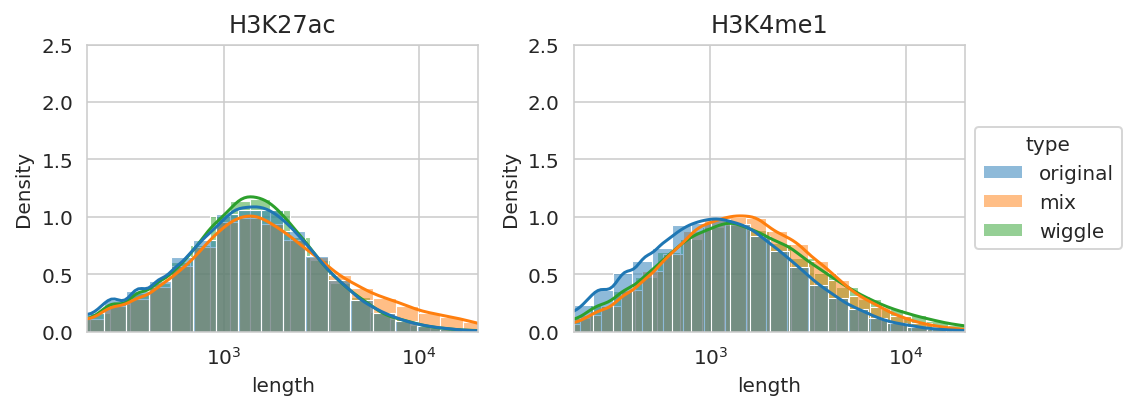

In [526]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='type', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


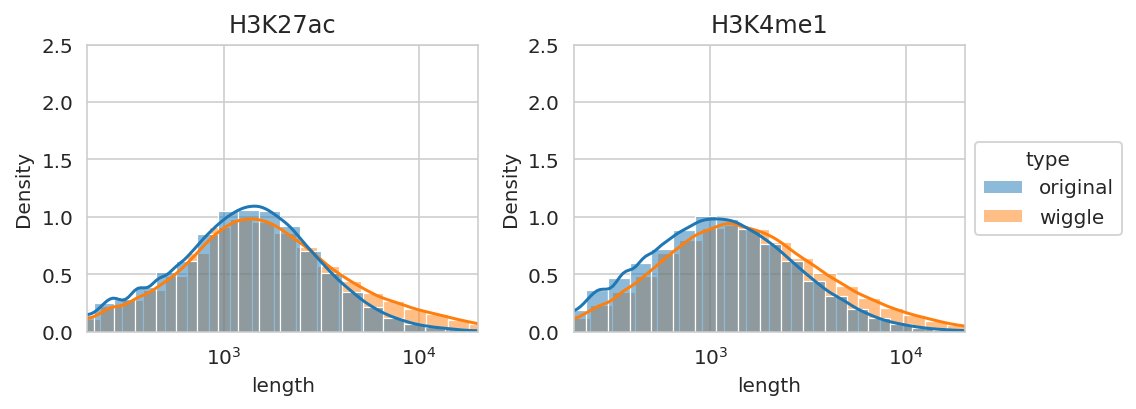

In [569]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & 
                                    (t['tool'] == 'SPAN') & 
                                    (t['type'].isin(['original', 'wiggle']))],
                             x='length', hue='type', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


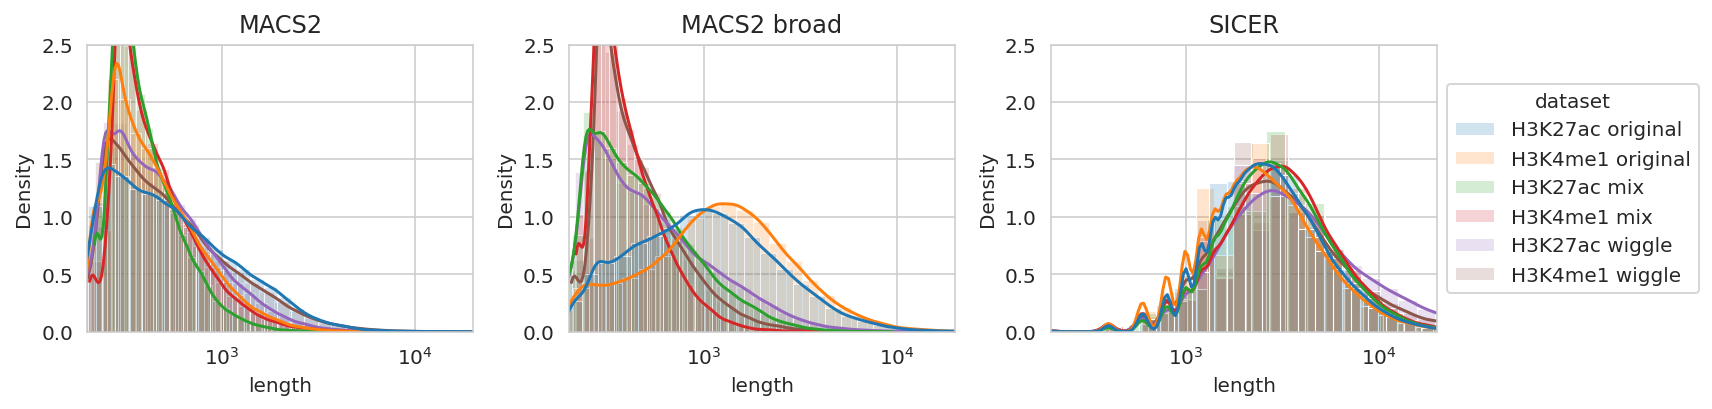

In [527]:
t['dataset'] = t['modification'] + ' ' + t['type']

plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(data=t[t['tool'] == tool],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 2:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


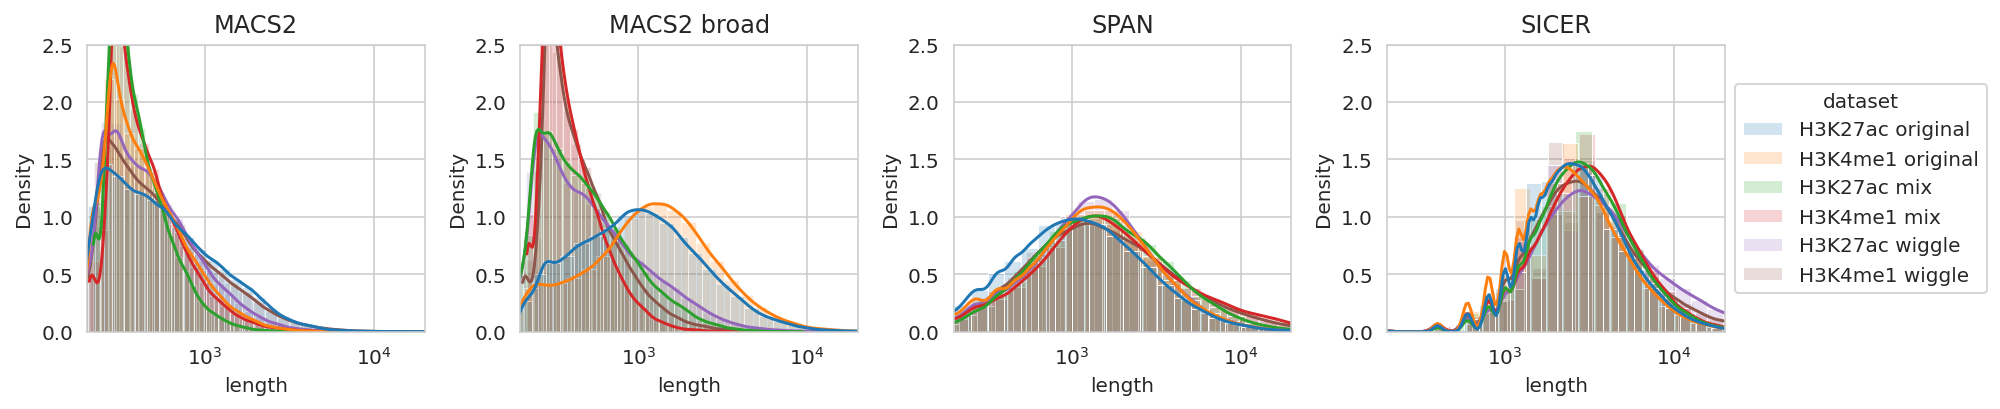

In [528]:
t['dataset'] = t['modification'] + ' ' + t['type']

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SPAN', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(data=t[t['tool'] == tool],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

## Variance of coverage within peaks

In [529]:
wiggle_mix_peaks

,file,modification,cell,replicate,peaks,tool,name,type
0,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K4me1,HMEC,rep1,3416,MACS2,MACS2 mix,mix
1,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K4me1,HepG2,rep1,65045,MACS2,MACS2 wiggle,wiggle
2,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K4me1,GM12878,rep1,11904,MACS2,MACS2 mix,mix
3,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K4me1,NHLF,rep1,2790,MACS2,MACS2 mix,mix
4,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,K562,rep1,31151,MACS2,MACS2 mix,mix
...,...,...,...,...,...,...,...,...
123,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,HepG2,rep1,22957,SPAN,SPAN wiggle,wiggle
124,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K4me1,NHLF,rep1,59275,SPAN,SPAN wiggle,wiggle
125,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,HMEC,rep1,36254,SPAN,SPAN mix,mix
126,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,HMEC,rep1,41809,SPAN,SPAN wiggle,wiggle


In [549]:
all_wiggle_mix_roadmap_peaks = pd.concat([df_peaks[(df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])) & (df_peaks['cell'] != 'H1')], 
                                          wiggle_mix_peaks]).reset_index(drop=True)
all_wiggle_mix_roadmap_peaks['dataset'] = [ds if ty == 'original' else ty for ds, ty in zip(all_wiggle_mix_roadmap_peaks['dataset'], all_wiggle_mix_roadmap_peaks['type'])]
all_wiggle_mix_roadmap_peaks.sample(3)

,file,modification,cell,replicate,peaks,tool,dataset,name,type
209,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K4me1,HepG2,rep1,53845,SICER,mix,SICER mix,mix
68,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me1,HepG2,rep1,69630,SICER,ENCODE,SICER,original
113,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,NHEK,rep1,48853,SPAN,ENCODE,SPAN,original


In [531]:
! mkdir -p {WD}/union

for m, ds in tqdm(product(['H3K27ac', 'H3K4me1'], ['ENCODE', 'wiggle', 'mix', 'Roadmap'])):
    print('---')
    print(m, ds)
    tmdt = all_wiggle_mix_roadmap_peaks[(all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                        (all_wiggle_mix_roadmap_peaks['dataset'] == ds)]
    if len(tmdt) == 0:
        continue
    for _, (c, r) in tmdt[['cell', 'replicate']].drop_duplicates().iterrows():
        t = tmdt[(tmdt['cell'] == c) & (tmdt['replicate'] == r)]
        if len(t) == 0:
            continue
        print(c, r)
        try:
            files = t[t['tool'] == 'SPAN']['file']
            t_span = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'MACS2']['file']
            t_macs2 = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'MACS2 broad']['file']
            t_macs2broad = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'SICER']['file']
            t_sicer = sorted_file(files.values[0]) if len(files) == 1 else ''
            tf = tempfile.mktemp()
            # Prepare total overlap
            union_path = f'{WD}/union/{m}_{c}_{r}_{ds}.bed'
            ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
            ! bedtools merge -i {tf} > {union_path}
            print(union_path)
        except Exception as e:
            print(e)
            break
            pass

0it [00:00, ?it/s]

---
H3K27ac ENCODE
HepG2 rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HepG2_rep2_ENCODE.bed
GM12878 rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_GM12878_rep2_ENCODE.bed
NHLF rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_NHLF_rep2_ENCODE.bed
HepG2 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HepG2_rep1_ENCODE.bed
K562 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_K562_rep1_ENCODE.bed
HSMM rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HSMM_rep2_ENCODE.bed
Huvec rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_Huvec_rep1_ENCODE.bed
HSMM rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HSMM_rep1_ENCODE.bed
GM12878 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_GM12878_rep1_ENCODE.bed
HMEC rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HMEC_rep1_ENCODE.bed
NHEK rep2
/home/jetbrains/data/2023_GSE26320_wiggle_m

In [532]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}

In [533]:
def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws

In [534]:
encode_bws = load_bws(GSE26320_PATH + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
encode_bws['dataset'] = 'ENCODE'
encode_bws.sample(3)

  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate,dataset
61,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,H3K27ac,GM12878,rep2,ENCODE
99,/home/jetbrains/data/2023_GSE26320/bw/GSM64646...,H3K4me1,NHEK,rep2,ENCODE
37,/home/jetbrains/data/2023_GSE26320/bw/GSM64645...,Control,K562,rep2,ENCODE


In [535]:
immune_bws = load_bws(IMMUNE_PATH + '/bw', MODIFICATIONS, IMMUNE_CELLS, [''], 'Control')
immune_bws['dataset'] = 'Roadmap'
immune_bws.sample(3)

  0%|          | 0/17 [00:00<?, ?it/s]

,file,modification,cell,replicate,dataset
2,/home/jetbrains/data/2023_Immune/bw/TCell_H3K4...,H3K4me1,TCell,,Roadmap
0,/home/jetbrains/data/2023_Immune/bw/BCell_H3K3...,H3K36me3,BCell,,Roadmap
8,/home/jetbrains/data/2023_Immune/bw/BCell_Cont...,Control,BCell,,Roadmap


In [536]:
mix_wiggle_bws = load_bws(WD + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
mix_wiggle_bws['dataset'] = ['wiggle' if 'wiggle.bw' in f else 'mix' for f in mix_wiggle_bws['file']] 
mix_wiggle_bws.sample(3)

  0%|          | 0/40 [00:00<?, ?it/s]

,file,modification,cell,replicate,dataset
28,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,HMEC,rep1,wiggle
18,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,Control,NHEK,rep1,mix
0,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,Control,HSMM,rep1,mix


In [537]:
df_bws = pd.concat([encode_bws, immune_bws, mix_wiggle_bws]).reset_index(drop=True)
df_bws.sample(3)

,file,modification,cell,replicate,dataset
25,/home/jetbrains/data/2023_GSE26320/bw/GSM64632...,H3K36me3,GM12878,rep1,ENCODE
145,/home/jetbrains/data/2023_GSE26320_wiggle_mix/...,H3K27ac,GM12878,rep1,mix
3,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,H3K27me3,HepG2,rep2,ENCODE


## Compute variance of coverage withing peaks

In [538]:
from math import ceil
import pyBigWig

variances = []
bin = 100

t = all_wiggle_mix_roadmap_peaks[['dataset', 'modification', 'cell', 'replicate']].drop_duplicates()
for dt, m, c, r in tqdm(zip(t['dataset'], t['modification'], t['cell'], t['replicate'])):
    if m == 'Control':
        continue
    print(dt, m, c, r)
    union_path = f'{WD}/union/{m}_{c}_{r}_{dt}.bed'
    print(union_path)
    try:
        bw_path = df_bws[(df_bws['dataset'] == dt) &
                         (df_bws['modification'] == m) & (df_bws['cell'] == c) &
                         (df_bws['replicate'] == r)]['file'].values[0]
        print(bw_path)
        t = pd.read_csv(union_path, sep='\t', header=None)
        t = t.sample(min(len(t), 1000))
        with pyBigWig.open(bw_path) as bw:
            # Resort top scored peaks by density and start with the most dense ones
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            print('Total coverage', total_coverage)
            for chr, start, end in zip(t[0], t[1], t[2]):
                if chr in CHROM_SIZES:
                    # Normalize by total coverage
                    stats = [c / total_coverage for c in bw.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True)]
                    variances.append((dt, m, c, r, f'{chr}:{start}-{end}', np.var(stats)))
    except Exception as e:
        print(e)
        break
        pass  # Ignore

df_vars = pd.DataFrame(variances, columns=['datatype', 'modification', 'cell',  'replicate', 'position', 'variance'])
del variances
df_vars.sample(5)

0it [00:00, ?it/s]

ENCODE H3K27ac HepG2 rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HepG2_rep2_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646356_HepG2_H3K27ac_rep2.bw
Total coverage 81.26528048207307
ENCODE H3K27ac GM12878 rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_GM12878_rep2_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646317_GM12878_H3K27ac_rep2.bw
Total coverage 96.86748202932358
ENCODE H3K27ac NHLF rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_NHLF_rep2_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646477_NHLF_H3K27ac_rep2.bw
Total coverage 78.84905029224777
ENCODE H3K27ac HepG2 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HepG2_rep1_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646355_HepG2_H3K27ac_rep1.bw
Total coverage 79.22861050548816
ENCODE H3K4me1 HMEC rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K4me1_HMEC_rep1_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646380

,datatype,modification,cell,replicate,position,variance
29508,ENCODE,H3K27ac,NHEK,rep1,chr1:154728800-154731199,0.000002
14731,ENCODE,H3K4me1,HMEC,rep2,chr3:153591200-153592199,0.000001
27289,ENCODE,H3K4me1,GM12878,rep2,chr2:135161200-135163799,0.000002
53022,wiggle,H3K27ac,HMEC,rep1,chr1:170933400-170936799,0.000001
40918,mix,H3K4me1,K562,rep1,chrX:23883000-23885244,0.000002


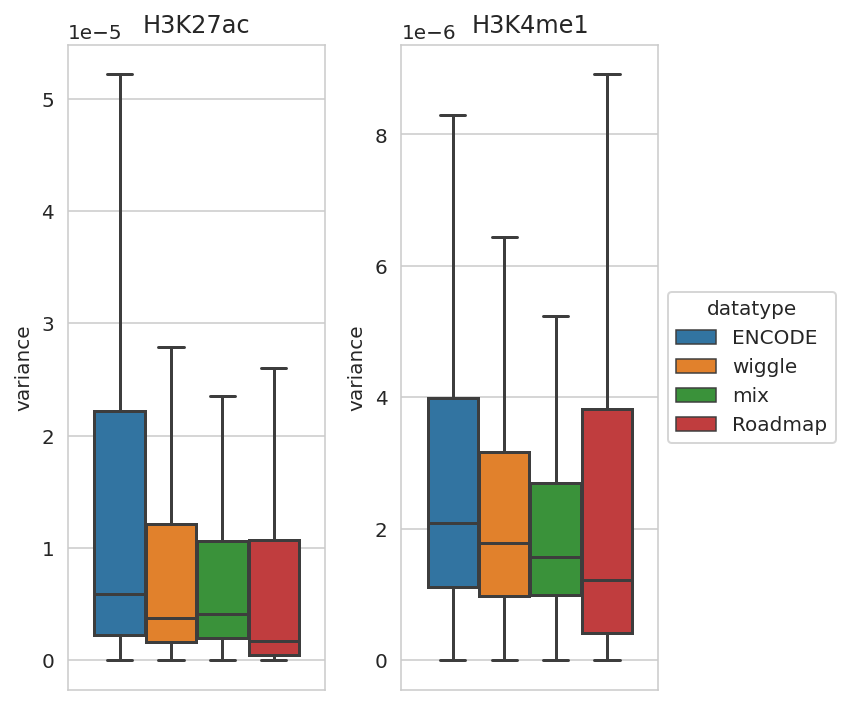

In [539]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_vars[df_vars['modification'] == m], x='modification', y='variance',  hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

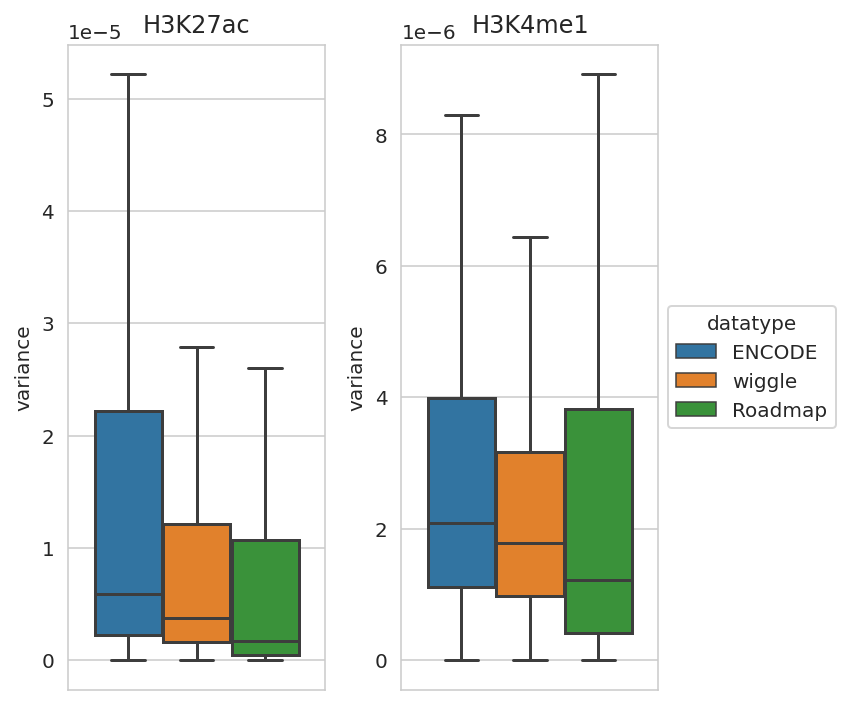

In [540]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_vars[df_vars['modification'] == m], x='modification', y='variance',  hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

## Compute signal/control ratio within peaks

In [558]:
from math import ceil
import pyBigWig

ratios = []

t = all_wiggle_mix_roadmap_peaks[['dataset', 'modification', 'cell', 'replicate']].drop_duplicates()
for dt, m, c, r in tqdm(zip(t['dataset'], t['modification'], t['cell'], t['replicate'])):
    if m == 'Control':
        continue
    print(dt, m, c, r)
    union_path = f'{WD}/union/{m}_{c}_{r}_{dt}.bed'
    print(union_path)
    control_dt = 'Roadmap' if dt == 'Roadmap' else 'ENCODE'
    try:
        bw_path = df_bws[(df_bws['dataset'] == dt) &
                         (df_bws['modification'] == m) & (df_bws['cell'] == c) &
                         (df_bws['replicate'] == r)]['file'].values[0]
        print(bw_path)
        bwc_path = df_bws[(df_bws['dataset'] == control_dt) &
                          (df_bws['modification'] == 'Control') & (df_bws['cell'] == c) &
                          (df_bws['replicate'] == r)]['file'].values[0]
        print(bwc_path)
        t = pd.read_csv(union_path, sep='\t', header=None)
        t = t.sample(min(len(t), 1000))
        with pyBigWig.open(bw_path) as bw:
            # Resort top scored peaks by density and start with the most dense ones
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            print('Total signal coverage', total_coverage)
            with pyBigWig.open(bwc_path) as bwc:
                # Resort top scored peaks by density and start with the most dense ones
                total_coveragec = sum(bwc.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
                print('Total control coverage', total_coveragec)

                for chr, start, end in zip(t[0], t[1], t[2]):
                    if chr in CHROM_SIZES:
                        # Normalize by total coverage
                        signal = bw.stats(chr, start, end, exact=True, type='sum')[0] / total_coverage
                        noise = bwc.stats(chr, start, end, exact=True, type='sum')[0] / total_coveragec
                        ratios.append((dt, m, c, r, f'{chr}:{start}-{end}', (signal + 1e-10) / (noise + 1e-10)))
    except:
        pass  # Ignore

df_signal_to_noises = pd.DataFrame(ratios, columns=['datatype', 'modification', 'cell', 'replicate', 'position', 'signal_to_control'])
del ratios
df_signal_to_noises.sample(5)

0it [00:00, ?it/s]

ENCODE H3K27ac HepG2 rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HepG2_rep2_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646356_HepG2_H3K27ac_rep2.bw
/home/jetbrains/data/2023_GSE26320/bw/GSM646371_HepG2_Input_rep2.bw
Total signal coverage 81.26528048207307
Total control coverage 84.38019864613723
ENCODE H3K27ac GM12878 rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_GM12878_rep2_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646317_GM12878_H3K27ac_rep2.bw
/home/jetbrains/data/2023_GSE26320/bw/GSM646333_GM12878_Input_rep2.bw
Total signal coverage 96.86748202932358
Total control coverage 98.62312218796158
ENCODE H3K27ac NHLF rep2
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_NHLF_rep2_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646477_NHLF_H3K27ac_rep2.bw
/home/jetbrains/data/2023_GSE26320/bw/GSM646493_NHLF_Input_rep2.bw
Total signal coverage 78.84905029224777
Total control coverage 82.04798513630486
ENCODE H3K27ac 

,datatype,modification,cell,replicate,position,signal_to_control
55826,mix,H3K4me1,Huvec,rep1,chr5:163460600-163464799,2.957907
51372,wiggle,H3K27ac,NHEK,rep1,chr2:36887800-36891999,6.094462
39553,mix,H3K27ac,K562,rep1,chr1:151197600-151200599,4.182733
39018,mix,H3K27ac,K562,rep1,chr8:54013000-54024199,5.730818
41725,wiggle,H3K4me1,Huvec,rep1,chr10:96614713-96614975,2.375443


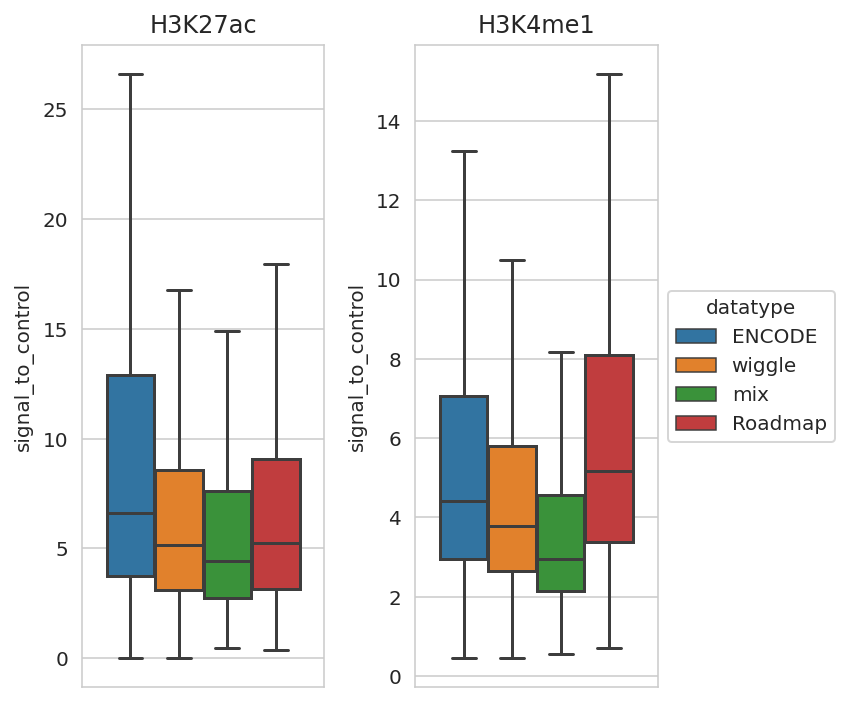

In [559]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_signal_to_noises[df_signal_to_noises['modification'] == m], x='modification', y='signal_to_control',  hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

# Signal-to-noise ratio

In [570]:
# TODO

# Jaccard vs original peaks

In [552]:
bench_df = pd.DataFrame(
    columns=['dataset', 'modification', 'cell', 'replicate', 'name', 'type',
             'original_peaks', 'original_peaks_len',
             'peaks', 'peaks_len', 'overlap1', 'overlap2', 'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for ds, m, c, r, tool in tqdm(
        [('ENCODE', m, c, r, tool) for m, c, r, tool in product(['H3K27ac', 'H3K4me1'], GSE26320_CELLS, GSE26320_REPS, TOOLS)] +
        [('Roadmap', m, c, r, tool) for m, c, r, tool in product(['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, [''], TOOLS)]
):
    print(ds, m, c, r, tool)
    t = all_wiggle_mix_roadmap_peaks[
        # (all_wiggle_mix_roadmap_peaks['dataset'] == ds) &
                                     (all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                     (all_wiggle_mix_roadmap_peaks['cell'] == c) &
                                     (all_wiggle_mix_roadmap_peaks['replicate'] == r) &
                                     (all_wiggle_mix_roadmap_peaks['tool'] == tool) &
                                     (all_wiggle_mix_roadmap_peaks['type'] == 'original')]
    if len(t) == 0:
        print('-')
        continue
    original_file = sorted_file(t['file'].values[0])
    original_peaks = lines(original_file)
    original_peaks_len = int(bedl(original_file).sum())
    for ty in ['wiggle', 'mix']:
        t = all_wiggle_mix_roadmap_peaks[
            # (all_wiggle_mix_roadmap_peaks['dataset'] == ds) &
                                         (all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                         (all_wiggle_mix_roadmap_peaks['cell'] == c) &
                                         (all_wiggle_mix_roadmap_peaks['replicate'] == r) &
                                         (all_wiggle_mix_roadmap_peaks['tool'] == tool) &
                                         (all_wiggle_mix_roadmap_peaks['type'] == ty)]
        if len(t) == 0:
            print(ty, '--')
            continue
        file = sorted_file(t['file'].values[0])
        peaks = lines(file)
        peaks_len = int(bedl(file).sum())
        !bedtools intersect -a {original_file} -b {file} -wa -u > {tf}
        overlap1 = lines(tf)
        !bedtools intersect -b {original_file} -a {file} -wa -u > {tf}
        overlap2 = lines(tf)
        !bedtools intersect -a {original_file} -b {file} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        bench_df.loc[len(bench_df)] = \
            (ds, m, c, r, tool, ty,
             original_peaks, original_peaks_len,
             peaks, peaks_len, overlap1, overlap2, overlap_len)

display(bench_df.sample(3))


  0%|          | 0/160 [00:00<?, ?it/s]

ENCODE H3K27ac GM12878 rep1 MACS2
ENCODE H3K27ac GM12878 rep1 MACS2 broad
ENCODE H3K27ac GM12878 rep1 SPAN
ENCODE H3K27ac GM12878 rep1 SICER
ENCODE H3K27ac GM12878 rep2 MACS2
wiggle --
mix --
ENCODE H3K27ac GM12878 rep2 MACS2 broad
wiggle --
mix --
ENCODE H3K27ac GM12878 rep2 SPAN
wiggle --
mix --
ENCODE H3K27ac GM12878 rep2 SICER
wiggle --
mix --
ENCODE H3K27ac HMEC rep1 MACS2
ENCODE H3K27ac HMEC rep1 MACS2 broad
ENCODE H3K27ac HMEC rep1 SPAN
ENCODE H3K27ac HMEC rep1 SICER
ENCODE H3K27ac HMEC rep2 MACS2
wiggle --
mix --
ENCODE H3K27ac HMEC rep2 MACS2 broad
wiggle --
mix --
ENCODE H3K27ac HMEC rep2 SPAN
wiggle --
mix --
ENCODE H3K27ac HMEC rep2 SICER
wiggle --
mix --
ENCODE H3K27ac HSMM rep1 MACS2
ENCODE H3K27ac HSMM rep1 MACS2 broad
ENCODE H3K27ac HSMM rep1 SPAN
ENCODE H3K27ac HSMM rep1 SICER
ENCODE H3K27ac HSMM rep2 MACS2
wiggle --
mix --
ENCODE H3K27ac HSMM rep2 MACS2 broad
wiggle --
mix --
ENCODE H3K27ac HSMM rep2 SPAN
wiggle --
mix --
ENCODE H3K27ac HSMM rep2 SICER
wiggle --
mix -

,dataset,modification,cell,replicate,name,type,original_peaks,original_peaks_len,peaks,peaks_len,overlap1,overlap2,overlap_len
125,ENCODE,H3K4me1,HepG2,rep1,SPAN,mix,88821,168825801,60055,131318526,59585,59234,123873334
113,ENCODE,H3K4me1,Huvec,rep1,MACS2,mix,87943,60491566,37215,17445078,28771,37214,17435105
1,ENCODE,H3K27ac,GM12878,rep1,MACS2,mix,47290,41890163,33815,21222136,22953,33807,21198387


In [553]:
bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['original_peaks_len'], bench_df['peaks_len'], bench_df['overlap_len'])
]
bench_df.sample(1)


,dataset,modification,cell,replicate,name,type,original_peaks,original_peaks_len,peaks,peaks_len,overlap1,overlap2,overlap_len,jaccard
37,ENCODE,H3K27ac,NHEK,rep1,SPAN,mix,48853,83733829,35378,59794626,34359,35320,59040204,0.698798


H3K27ac
H3K4me1


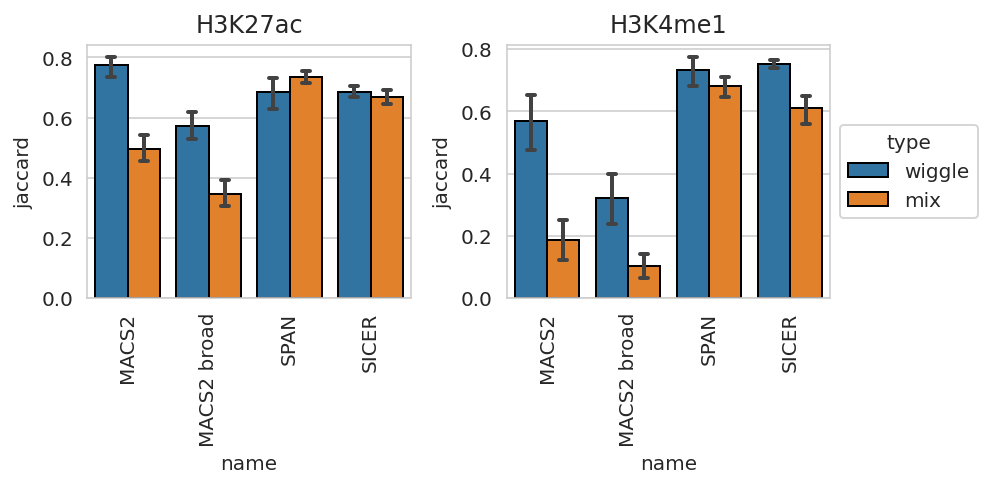

In [557]:
plt.figure(figsize=(7, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=bench_df[bench_df['modification'] == m],
                            x='name', hue='type', y='jaccard', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            hue_order=['wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

wiggle
H3K27ac
H3K4me1


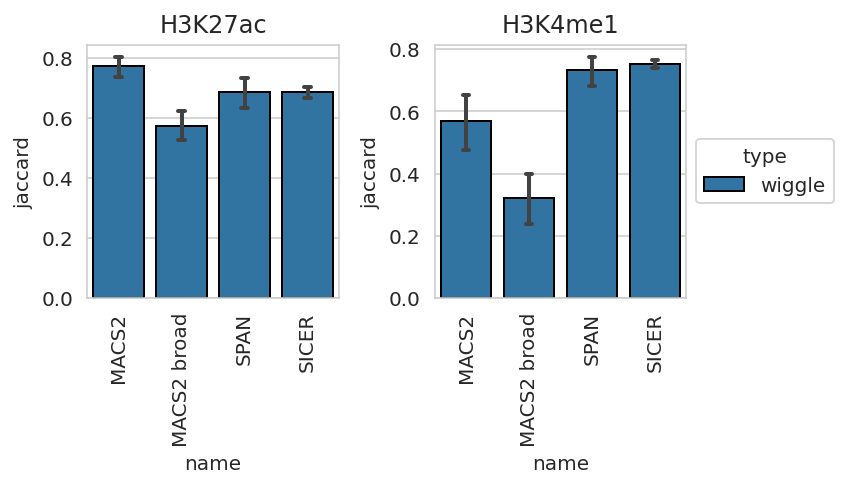

mix
H3K27ac
H3K4me1


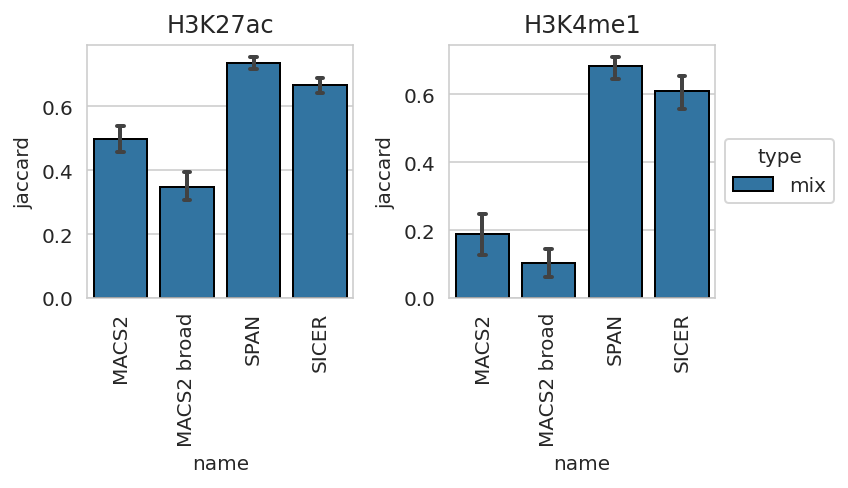

In [562]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(6, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.barplot(data=bench_df[(bench_df['type'] == ty) & (bench_df['modification'] == m)],
                                x='name', hue='type', y='jaccard', ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                # hue_order=['wiggle', 'mix'],
                                # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

In [585]:
xs = [2,3,5,12,25,28,12,7,3,3]
print(sum(xs), np.var(xs))

ys = [2,5,7,15,17,18,17,11,5,3]
print(sum(ys), np.var(ys))

100 80.2
100 36.0


# END